# Reviews are KING - Project Notebook

#### Team members: Shengzhao LEI - Tao SUN -  Xiangzhe MENG

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

## 1 - Data preprocessing

### 1.1 - Load Kindle store product data

In [2]:
df_kindle_meta = pd.read_pickle('pickleDataNew/kindle_metadata.pkl')

There are **61682** kindle store products and because of our previous work, each of them have reviews.

In [3]:
df_kindle_meta.shape

(61682, 2)

In [4]:
df_kindle_meta.head()

price                                         categories
asin                                                                
B000F83SZQ   0.00  [[Books, Literature & Fiction], [Books, Myster...
B000FA64QO   5.99  [[Books, Literature & Fiction, Genre Fiction, ...
B000FA64PA   4.58  [[Books, Comics & Graphic Novels], [Books, Sci...
B000FA64PK   5.99  [[Books, Comics & Graphic Novels, Graphic Nove...
B000FBFMVG   1.99  [[Books, Literature & Fiction, Genre Fiction, ...

In [11]:
df_kindle_meta.iloc[0].categories

[['Books', 'Literature & Fiction'],
 ['Books', 'Mystery, Thriller & Suspense', 'Thrillers & Suspense', 'Suspense'],
 ['Kindle Store', 'Kindle eBooks', 'Mystery, Thriller & Suspense', 'Suspense']]

We notice that the categories of products in Amazon are hierarchical. And each book may belong to several different categories. So, we need to change the format of categories in our dataset.

### 1.2 - Reshape Kindle product and review dataframe by category

Below is the process of reshaping the category information. We want to unzip the hierarchical category in order to analyze the category of each book directly. We find that for all kindle books, the first category must be **Kindle Store** which we don't need.

In [12]:
kindle_cat = []
for idx in df_kindle_meta.index:
    cat = df_kindle_meta.loc[idx].categories
    for catcat in cat:
        if catcat[0]=='Kindle Store':
            kindle_cat.append([idx]+catcat[1:])
        else:
            kindle_cat.append([idx]+catcat)

In [13]:
df_kindle_category = pd.DataFrame(kindle_cat)
df_kindle_category.columns = ['asin','1st','2nd','3rd','4th','5th','6th','7th']
df_kindle_category.set_index('asin',inplace=True)
df_kindle_category.head()

1st                           2nd                   3rd  \
asin                                                                            
B000F83SZQ          Books          Literature & Fiction                  None   
B000F83SZQ          Books  Mystery, Thriller & Suspense  Thrillers & Suspense   
B000F83SZQ  Kindle eBooks  Mystery, Thriller & Suspense              Suspense   
B000FA64QO          Books          Literature & Fiction         Genre Fiction   
B000FA64QO          Books     Science Fiction & Fantasy       Science Fiction   

                      4th   5th   6th   7th  
asin                                         
B000F83SZQ           None  None  None  None  
B000F83SZQ       Suspense  None  None  None  
B000F83SZQ           None  None  None  None  
B000FA64QO  Movie Tie-Ins  None  None  None  
B000FA64QO    Space Opera  None  None  None

In [14]:
df_kindle_category.to_pickle('pickleDataNew/kindle_cat.pkl')

Now, let's do some very basic analysis about our category information.

In [15]:
df_kindle_category = pd.read_pickle('pickleDataNew/kindle_cat.pkl')

In [16]:
df_kindle_category.head()

1st                           2nd                   3rd  \
asin                                                                            
B000F83SZQ          Books          Literature & Fiction                  None   
B000F83SZQ          Books  Mystery, Thriller & Suspense  Thrillers & Suspense   
B000F83SZQ  Kindle eBooks  Mystery, Thriller & Suspense              Suspense   
B000FA64QO          Books          Literature & Fiction         Genre Fiction   
B000FA64QO          Books     Science Fiction & Fantasy       Science Fiction   

                      4th   5th   6th   7th  
asin                                         
B000F83SZQ           None  None  None  None  
B000F83SZQ       Suspense  None  None  None  
B000F83SZQ           None  None  None  None  
B000FA64QO  Movie Tie-Ins  None  None  None  
B000FA64QO    Space Opera  None  None  None

`1st` of category represents the biggest groups that the book belongs to.

In [17]:
df_kindle_category['1st'].value_counts()

Kindle eBooks         145691
Books                 143778
Kindle Short Reads     24078
Kindle Singles           338
Kindle Worlds             70
Sports & Outdoors          1
Toys & Games               1
TestNode                   1
Name: 1st, dtype: int64

Out of our surprise, besides **Books** and **Kindle eBooks**, there are other categories, like **Kindle Short Reads**, which is very interesting and we have a large amount of reviews/metadata related to it. We can do some extra analysis also on this category. So, we decide to also keep it.

After observing the whole dataframe and the category structure, we decide to use two categories **Books** and **Kindle Short Reads** for our project.

#### 1.2.1 - SubCategories of Kindle book products

In [93]:
df_kindle_category[df_kindle_category['1st'] == 'Books']['2nd'].value_counts()

Literature & Fiction            47074
Romance                         35096
Science Fiction & Fantasy       10514
Mystery, Thriller & Suspense     9633
Health, Fitness & Dieting        4946
Children's Books                 4590
Cookbooks, Food & Wine           4547
Gay & Lesbian                    4060
Self-Help                        3036
Teen & Young Adult               2758
Business & Money                 2515
Christian Books & Bibles         2483
Religion & Spirituality          2437
Crafts, Hobbies & Home           1569
Reference                        1325
Humor & Entertainment            1106
Biographies & Memoirs            1016
Parenting & Relationships         894
Computers & Technology            752
Travel                            496
History                           488
Education & Teaching              420
Politics & Social Sciences        369
Arts & Photography                366
Medical Books                     353
Sports & Outdoors                 342
Science & Ma

#### 1.2.2 - SubCategories of Kindle short read products

In this part, we decide to collect all kindle products with category **Kindle Short Reads** and classify these products with these 6 sub-categories shown below:

- Two hours or more (65-100 pages)
- 90 minutes (44-64 pages)
- 45 minutes (22-32 pages)
- One hour (33-43 pages)
- 30 minutes (12-21 pages)
- 15 minutes (1-11 pages)

In [92]:
df_kindle_category[df_kindle_category['1st'] == 'Kindle Short Reads']['2nd'].value_counts()

Two hours or more (65-100 pages)    7742
90 minutes (44-64 pages)            5980
45 minutes (22-32 pages)            3982
One hour (33-43 pages)              3980
30 minutes (12-21 pages)            2001
15 minutes (1-11 pages)              393
Name: 2nd, dtype: int64

In this part, we select all metadata of the kindle short reads product and create a new dataframe **df_kindle_short_read_meta**.

In [135]:
# Collect all kindle short read product asin
asin_kindle_short_read = df_kindle_category[df_kindle_category['1st'] == 'Kindle Short Reads']
asin_kindle_short_read = asin_kindle_short_read.filter(items = ['2nd'], axis = 1)
asin_kindle_short_read = asin_kindle_short_read.reset_index()
asin_kindle_short_read = asin_kindle_short_read.drop_duplicates(subset = 'asin')
asin_kindle_short_read = asin_kindle_short_read.set_index('asin')

# Collect all kindle short read products
df_kindle_short_read_meta = df_kindle_meta.loc[list(asin_kindle_short_read.index)]
df_kindle_short_read_meta = df_kindle_short_read_meta.drop(['categories'],axis = 1)

# Add sub-category for each product
df_kindle_short_read_meta = df_kindle_short_read_meta.merge(asin_kindle_short_read,left_index=True, right_index=True,how="inner")
df_kindle_short_read_meta.columns = ['price','category']
df_kindle_short_read_meta.head()

price                          category
asin                                               
B000FBFMVG   1.99  Two hours or more (65-100 pages)
B000JMKNQ0   7.99  Two hours or more (65-100 pages)
B000JMKXYW   0.99  Two hours or more (65-100 pages)
B000JML2H4   3.99          30 minutes (12-21 pages)
B000JMLG4S   0.99          90 minutes (44-64 pages)

##### Merge kindle short read product and review dataframe

In [ ]:
df_kindle_short_read_review = df_kindle_review.merge(df_kindle_short_read_meta,left_index=True, right_index=True,how="inner")

##### Update pickle file

In [142]:
df_kindle_short_read_review.to_pickle("pickleDataNew/kindle_short_read_review.pkl")

### 1.3 - Update overall by taking helpful rate into consideration

`helpful rate` is very interesting and we want to make use of it. It shows how useful and reliable one's review and rating is. So, we use `helpful rate` to modify the rating information of every review as following:

$$HelpfulRate = \begin{cases}\dfrac{\# Helpful}{\# Voting}& \# Voting \neq 0\\ 1& \# Voting = 0 \end{cases}$$


$$ModifiedRate = \begin{cases}Rate+1& Rate\leq2,HelpfulRate\leq\dfrac{1}{3}\\Rate-1& Rate\geq4, HelpfulRate\leq\dfrac{1}{3}\\Rate& \text{Otherwise}\end{cases}$$

We assume that overall rating is not reasonable if the helpful rate is smaller than 1/3. Thus, if the unreasonable overall is smaller than 2 we add 1 point to the overall. If the unreasonable overall is larger than 4 we substract 1 point to the overall.

We modify all of our rating information for kindle data and book data as well.

##### Kindle short read review

In [200]:
# Load kindle short read review pickle file
df_kindle_short_read_review = pd.read_pickle('pickleDataNew/kindle_short_read_review.pkl')

In [202]:
# Divide the column helpful into two parts
# up --> number of helpful votes
# total --> number of total votes
up = df_kindle_short_read_review['helpful'].apply(lambda x: x[0])
total = df_kindle_short_read_review['helpful'].apply(lambda x: x[1])
 
# Compute helpful rate
df_kindle_short_read_review['helpful rate'] = up/total

# Add helful rate column and fill the nan value with 1
df_kindle_short_read_review['helpful rate'] = df_kindle_short_read_review['helpful rate'].fillna(1).map('{:,.2f}'.format)

# Drop helpful column
df_kindle_short_read_review = df_kindle_short_read_review.drop(['helpful'],axis = 1)

In [218]:
# Change data type for overall and helpful rate columns
df_kindle_short_read_review['overall'] = df_kindle_short_read_review['overall'].astype(float)
df_kindle_short_read_review['helpful rate'] = df_kindle_short_read_review['helpful rate'].astype(float)

# Compute new rate
rate = []
for idx in range(df_kindle_short_read_review.shape[0]):
    if df_kindle_short_read_review.iloc[idx]['helpful rate'] <= 1/3 and df_kindle_short_read_review.iloc[idx]['overall'] >= 4:
        rate.append(df_kindle_short_read_review.iloc[idx]['overall'] - 1)
    elif df_kindle_short_read_review.iloc[idx]['helpful rate'] <= 1/3 and df_kindle_short_read_review.iloc[idx]['overall'] <= 2:
        rate.append(df_kindle_short_read_review.iloc[idx]['overall'] + 1)
    else:
        rate.append(df_kindle_short_read_review.iloc[idx]['overall'])
        
# Add rate column        
df_kindle_short_read_review['rate'] = rate

# Drop overall and helpful rate colum
df_kindle_short_read_review = df_kindle_short_read_review.drop(['overall','helpful rate'],axis = 1)

# Reorder columns
df_kindle_short_read_review = df_kindle_short_read_review[['category','rate','price','summary','reviewText','unixReviewTime']]

In [226]:
df_kindle_short_read_review.to_pickle("pickleDataNew/kindle_short_read_review.pkl")

##### Kindle book review

In [2]:
# Load kindle book review pickle file
df_kindle_book_review = pd.read_pickle('pickleDataNew/kindle_book_review.pkl')

In [220]:
# Divide the column helpful into two parts
# up --> number of helpful votes
# total --> number of total votes
up = df_kindle_book_review['helpful'].apply(lambda x: x[0])
total = df_kindle_book_review['helpful'].apply(lambda x: x[1])

# Compute helpful rate
df_kindle_book_review['helpful rate'] = up/total

# Add helful rate column and fill the nan value with 1
df_kindle_book_review['helpful rate'] = df_kindle_book_review['helpful rate'].fillna(1).map('{:,.2f}'.format)

# Drop helpful column
df_kindle_book_review = df_kindle_book_review.drop(['helpful'],axis = 1)

In [222]:
# Change data type for overall and helpful rate columns
df_kindle_book_review['overall'] = df_kindle_book_review['overall'].astype(float)
df_kindle_book_review['helpful rate'] = df_kindle_book_review['helpful rate'].astype(float)

# Compute new rate
rate = []
for idx in range(df_kindle_book_review.shape[0]):
    if df_kindle_book_review.iloc[idx]['helpful rate'] <= 1/3 and df_kindle_book_review.iloc[idx]['overall'] >= 4:
        rate.append(df_kindle_book_review.iloc[idx]['overall'] - 1)
    elif df_kindle_book_review.iloc[idx]['helpful rate'] <= 1/3 and df_kindle_book_review.iloc[idx]['overall'] <= 2:
        rate.append(df_kindle_book_review.iloc[idx]['overall'] + 1)
    else:
        rate.append(df_kindle_book_review.iloc[idx]['overall'])

        
# Add rate column
df_kindle_book_review['rate'] = rate

# Drop overall and helpful rate colum
df_kindle_book_review = df_kindle_book_review.drop(['overall','helpful rate'],axis = 1)

# Reorder and rename columns
df_kindle_book_review = df_kindle_book_review[['Category','rate','Price','summary','reviewText','unixReviewTime']]
df_kindle_book_review.columns = ['category','rate','price','summary','reviewText','unixReviewTime']

In [240]:
df_kindle_book_review.to_pickle("pickleDataNew/kindle_book_review.pkl")

## 2 - Load useful data for data analysis

### 2.1 - Load Kindle short read reviews dataset

In [19]:
df_kindle_short_read_review = pd.read_pickle('pickleDataNew/kindle_short_read_review.pkl')

In [20]:
df_kindle_short_read_review

category  rate  price  \
asin                                                        
B000FBFMVG  Two hours or more (65-100 pages)   5.0   1.99   
B000FBFMVG  Two hours or more (65-100 pages)   3.0   1.99   
B000FBFMVG  Two hours or more (65-100 pages)   3.0   1.99   
B000FBFMVG  Two hours or more (65-100 pages)   5.0   1.99   
B000FBFMVG  Two hours or more (65-100 pages)   5.0   1.99   
B000FBFMVG  Two hours or more (65-100 pages)   5.0   1.99   
B000FBFMVG  Two hours or more (65-100 pages)   5.0   1.99   
B000FBFMVG  Two hours or more (65-100 pages)   4.0   1.99   
B000FBFMVG  Two hours or more (65-100 pages)   3.0   1.99   
B000JMKNQ0  Two hours or more (65-100 pages)   4.0   7.99   
B000JMKNQ0  Two hours or more (65-100 pages)   5.0   7.99   
B000JMKNQ0  Two hours or more (65-100 pages)   5.0   7.99   
B000JMKNQ0  Two hours or more (65-100 pages)   4.0   7.99   
B000JMKNQ0  Two hours or more (65-100 pages)   3.0   7.99   
B000JMKNQ0  Two hours or more (65-100 pages)   2.0   7.99   
B000JMKNQ0  Two hours or more (65-100 pages)   4.0   7.99   
B000JMKNQ0  Two hours or more (65-100 pages)   5.0   7.99   
B000JMKNQ0  Two hours or more (65-100 pages)   2.0   7.99   
B000JMKNQ0  Two hours or more (65-100 pages)   5.0   7.99   
B000JMKXYW  Two hours or more (65-100 pages)   5.0   0.99   
B000JMKXYW  Two hours or more (65-100 pages)   3.0   0.99   
B000JMKXYW  Two hours or more (65-100 pages)   5.0   0.99   
B000JMKXYW  Two hours or more (65-100 pages)   5.0   0.99   
B000JMKXYW  Two hours or more (65-100 pages)   3.0   0.99   
B000JMKXYW  Two hours or more (65-100 pages)   5.0   0.99   
B000JMKXYW  Two hours or more (65-100 pages)   1.0   0.99   
B000JMKXYW  Two hours or more (65-100 pages)   4.0   0.99   
B000JMKXYW  Two hours or more (65-100 pages)   5.0   0.99   
B000JMKXYW  Two hours or more (65-100 pages)   4.0   0.99   
B000JMKXYW  Two hours or more (65-100 pages)   5.0   0.99   
...                                      ...   ...    ...   
B00LWDMA5W  Two hours or more (65-100 pages)   5.0   0.99   
B00LWDMA5W  Two hours or more (65-100 pages)   5.0   0.99   
B00LWDMA5W  Two hours or more (65-100 pages)   4.0   0.99   
B00LWDMA5W  Two hours or more (65-100 pages)   5.0   0.99   
B00LXK4W2S  Two hours or more (65-100 pages)   5.0   2.99   
B00LXK4W2S  Two hours or more (65-100 pages)   5.0   2.99   
B00LXK4W2S  Two hours or more (65-100 pages)   5.0   2.99   
B00LXK4W2S  Two hours or more (65-100 pages)   5.0   2.99   
B00LXK4W2S  Two hours or more (65-100 pages)   5.0   2.99   
B00LXK4W2S  Two hours or more (65-100 pages)   5.0   2.99   
B00LXK4W2S  Two hours or more (65-100 pages)   5.0   2.99   
B00LXK4W2S  Two hours or more (65-100 pages)   5.0   2.99   
B00LXK4W2S  Two hours or more (65-100 pages)   5.0   2.99   
B00LXK4W2S  Two hours or more (65-100 pages)   5.0   2.99   
B00LXK4W2S  Two hours or more (65-100 pages)   5.0   2.99   
B00LXK4W2S  Two hours or more (65-100 pages)   5.0   2.99   
B00LXK4W2S  Two hours or more (65-100 pages)   5.0   2.99   
B00LXK4W2S  Two hours or more (65-100 pages)   5.0   2.99   
B00LY2DTG0  Two hours or more (65-100 pages)   5.0   0.99   
B00LY2DTG0  Two hours or more (65-100 pages)   5.0   0.99   
B00LY2DTG0  Two hours or more (65-100 pages)   5.0   0.99   
B00LY2DTG0  Two hours or more (65-100 pages)   4.0   0.99   
B00LY2DTG0  Two hours or more (65-100 pages)   5.0   0.99   
B00LY2DTG0  Two hours or more (65-100 pages)   5.0   0.99   
B00LY2DTG0  Two hours or more (65-100 pages)   5.0   0.99   
B00LYM5AUI  Two hours or more (65-100 pages)   5.0   0.99   
B00LYM5AUI  Two hours or more (65-100 pages)   5.0   0.99   
B00LYM5AUI  Two hours or more (65-100 pages)   5.0   0.99   
B00LYM5AUI  Two hours or more (65-100 pages)   5.0   0.99   
B00LYM5AUI  Two hours or more (65-100 pages)   5.0   0.99   

                                                      summary  \
asin                                                            
B000FBFMVG                        An interesting short story. 

This part shows us a brief statistic of the number of short read products for each category.

In [21]:
df_kindle_short_read_review['category'].value_counts()

Two hours or more (65-100 pages)    84407
90 minutes (44-64 pages)            57579
One hour (33-43 pages)              33675
45 minutes (22-32 pages)            32469
30 minutes (12-21 pages)            15537
15 minutes (1-11 pages)              2826
Name: category, dtype: int64

### 2.2 - Load kindle book reviews dataset

In [22]:
df_kindle_book_review = pd.read_pickle('pickleDataNew/kindle_book_review.pkl')

In [23]:
df_kindle_book_review

category  rate  price  \
asin                                                    
B000F83SZQ          Literature & Fiction   5.0   0.00   
B000F83SZQ          Literature & Fiction   4.0   0.00   
B000F83SZQ          Literature & Fiction   4.0   0.00   
B000F83SZQ          Literature & Fiction   5.0   0.00   
B000F83SZQ          Literature & Fiction   3.0   0.00   
B000F83SZQ          Literature & Fiction   4.0   0.00   
B000F83SZQ          Literature & Fiction   4.0   0.00   
B000F83SZQ          Literature & Fiction   4.0   0.00   
B000F83SZQ  Mystery, Thriller & Suspense   5.0   0.00   
B000F83SZQ  Mystery, Thriller & Suspense   4.0   0.00   
B000F83SZQ  Mystery, Thriller & Suspense   4.0   0.00   
B000F83SZQ  Mystery, Thriller & Suspense   5.0   0.00   
B000F83SZQ  Mystery, Thriller & Suspense   3.0   0.00   
B000F83SZQ  Mystery, Thriller & Suspense   4.0   0.00   
B000F83SZQ  Mystery, Thriller & Suspense   4.0   0.00   
B000F83SZQ  Mystery, Thriller & Suspense   4.0   0.00   
B000FA64PA       Comics & Graphic Novels   5.0   4.58   
B000FA64PA       Comics & Graphic Novels   4.0   4.58   
B000FA64PA       Comics & Graphic Novels   5.0   4.58   
B000FA64PA       Comics & Graphic Novels   4.0   4.58   
B000FA64PA       Comics & Graphic Novels   3.0   4.58   
B000FA64PA     Science Fiction & Fantasy   5.0   4.58   
B000FA64PA     Science Fiction & Fantasy   4.0   4.58   
B000FA64PA     Science Fiction & Fantasy   5.0   4.58   
B000FA64PA     Science Fiction & Fantasy   4.0   4.58   
B000FA64PA     Science Fiction & Fantasy   3.0   4.58   
B000FA64PA            Teen & Young Adult   5.0   4.58   
B000FA64PA            Teen & Young Adult   4.0   4.58   
B000FA64PA            Teen & Young Adult   5.0   4.58   
B000FA64PA            Teen & Young Adult   4.0   4.58   
...                                  ...   ...    ...   
B00M0RE7CS          Literature & Fiction   5.0   0.99   
B00M0RE7CS          Literature & Fiction   5.0   0.99   
B00M0RE7CS          Literature & Fiction   5.0   0.99   
B00M0RE7CS          Literature & Fiction   5.0   0.99   
B00M0RE7CS          Literature & Fiction   5.0   0.99   
B00M0RE7CS          Literature & Fiction   5.0   0.99   
B00M0RE7CS          Literature & Fiction   5.0   0.99   
B00M0RE7CS          Literature & Fiction   5.0   0.99   
B00M0RE7CS          Literature & Fiction   5.0   0.99   
B00M0RE7CS          Literature & Fiction   5.0   0.99   
B00M0RE7CS          Literature & Fiction   5.0   0.99   
B00M0RE7CS          Literature & Fiction   5.0   0.99   
B00M0RE7CS          Literature & Fiction   5.0   0.99   
B00M0RE7CS          Literature & Fiction   5.0   0.99   
B00M0RE7CS          Literature & Fiction   5.0   0.99   
B00M0RE7CS          Literature & Fiction   5.0   0.99   
B00M13FNSS          Literature & Fiction   4.0   0.00   
B00M13FNSS          Literature & Fiction   5.0   0.00   
B00M13FNSS          Literature & Fiction   5.0   0.00   
B00M13FNSS          Literature & Fiction   5.0   0.00   
B00M13FNSS          Literature & Fiction   5.0   0.00   
B00M13FNSS          Literature & Fiction   5.0   0.00   
B00M13FNSS          Literature & Fiction   5.0   0.00   
B00M13FNSS          Literature & Fiction   4.0   0.00   
B00M13FNSS          Literature & Fiction   5.0   0.00   
B00M13FNSS          Literature & Fiction   5.0   0.00   
B00M13FNSS          Literature & Fiction   5.0   0.00   
B00M13FNSS          Literature & Fiction   5.0   0.00   
B00M13FNSS          Literature & Fiction   5.0   0.00   
B00M13FNSS          Literature & Fiction   5.0   0.00   

                                                      summary  \
asin                                                            
B000F83SZQ                                 Nice vintage story   
B000F83SZQ                                       Different...   
B000F83SZQ                                              Oldie   
B000F83SZQ                                 I really liked it.   
B000F83SZQ                                     Per

This part shows us a brief statistic of the number of book products for each category.

In [24]:
df_kindle_book_review['category'].value_counts()

Literature & Fiction            839770
Romance                         705976
Mystery, Thriller & Suspense    167999
Science Fiction & Fantasy       162134
Children's Books                 51972
Health, Fitness & Dieting        49922
Gay & Lesbian                    49066
Cookbooks, Food & Wine           47842
Teen & Young Adult               45614
Christian Books & Bibles         33640
Religion & Spirituality          31205
Self-Help                        29808
Business & Money                 25907
Crafts, Hobbies & Home           16376
Reference                        15183
Humor & Entertainment            13759
Biographies & Memoirs            10663
Parenting & Relationships         9070
Computers & Technology            7914
Arts & Photography                4953
Travel                            4612
History                           4550
Politics & Social Sciences        4179
Education & Teaching              4077
Medical Books                     3530
Science & Math           

## 3 - Data analysis 

### 3.1 Score review text

We want to find the relationship between our review and our rating. The easiest way is to also give our review text a score which can represents whether it is positive or negative.

`NLTK` is a leading platform for building Python programs to work with human language data. In this project, we are going to use this library as our key tool for language processing.

`SentimentIntensityAnalyzer` is able to give a sentiment intensity score to sentences. The higher the score is, the more positive the sentence is. The score is normalized to a range of values between -1 and 1. In order to make it comparable with our 1-5 rate, we use linear transformation which linearly maps $(-1,1)$ to $(1,5)$:
$$reviewScoreNorm = 2\times reviewScore+3$$
We can use `reviewScoreNorm` as our predicted rate for each product.

And we calculate the difference score:
$$Diff = |reviewScoreNorm-Rate|$$

In [28]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [29]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/suntao/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [30]:
sid = SentimentIntensityAnalyzer()

In [31]:
df_review = df_kindle_book_review[['reviewText']]

In [32]:
df_review = df_review.drop_duplicates(subset = 'reviewText')

Apply score calculator on each entry.

In [33]:
df_review['reviewScore'] = df_review['reviewText'].apply(lambda x: sid.polarity_scores(x)['compound']).values

In [34]:
df_kindle_book_review_with_pred = pd.merge(df_kindle_book_review, df_review.reset_index(), left_on='reviewText', right_on='reviewText', how='inner')

In [35]:
df_kindle_book_review_with_pred = df_kindle_book_review_with_pred.set_index('asin')

Normalize the score.

In [36]:
df_kindle_book_review_with_pred['reviewScoreNorm'] = df_kindle_book_review_with_pred[['reviewScore']] * 2 + 3

In [37]:
df_kindle_book_review_with_pred

category  rate  price  \
asin                                                    
B000F83SZQ          Literature & Fiction   5.0   0.00   
B000F83SZQ  Mystery, Thriller & Suspense   5.0   0.00   
B000F83SZQ          Literature & Fiction   4.0   0.00   
B000F83SZQ  Mystery, Thriller & Suspense   4.0   0.00   
B000F83SZQ          Literature & Fiction   4.0   0.00   
B000F83SZQ  Mystery, Thriller & Suspense   4.0   0.00   
B000F83SZQ          Literature & Fiction   5.0   0.00   
B000F83SZQ  Mystery, Thriller & Suspense   5.0   0.00   
B000F83SZQ          Literature & Fiction   3.0   0.00   
B000F83SZQ  Mystery, Thriller & Suspense   3.0   0.00   
B000F83SZQ          Literature & Fiction   4.0   0.00   
B000F83SZQ  Mystery, Thriller & Suspense   4.0   0.00   
B000F83SZQ          Literature & Fiction   4.0   0.00   
B000F83SZQ  Mystery, Thriller & Suspense   4.0   0.00   
B000F83SZQ          Literature & Fiction   4.0   0.00   
B000F83SZQ  Mystery, Thriller & Suspense   4.0   0.00   
B000FA64PA       Comics & Graphic Novels   5.0   4.58   
B000FA64PA     Science Fiction & Fantasy   5.0   4.58   
B000FA64PA            Teen & Young Adult   5.0   4.58   
B000FA64PA       Comics & Graphic Novels   4.0   4.58   
B000FA64PA     Science Fiction & Fantasy   4.0   4.58   
B000FA64PA            Teen & Young Adult   4.0   4.58   
B000FA64PA       Comics & Graphic Novels   5.0   4.58   
B000FA64PA     Science Fiction & Fantasy   5.0   4.58   
B000FA64PA            Teen & Young Adult   5.0   4.58   
B000FA64PA       Comics & Graphic Novels   4.0   4.58   
B000FA64PA     Science Fiction & Fantasy   4.0   4.58   
B000FA64PA            Teen & Young Adult   4.0   4.58   
B000FA64PA       Comics & Graphic Novels   3.0   4.58   
B000FA64PA     Science Fiction & Fantasy   3.0   4.58   
...                                  ...   ...    ...   
B00M0RE7CS          Literature & Fiction   5.0   0.99   
B00M0RE7CS          Literature & Fiction   5.0   0.99   
B00M0RE7CS          Literature & Fiction   5.0   0.99   
B00M0RE7CS          Literature & Fiction   5.0   0.99   
B00M0RE7CS          Literature & Fiction   5.0   0.99   
B00M0RE7CS          Literature & Fiction   5.0   0.99   
B00M0RE7CS          Literature & Fiction   5.0   0.99   
B00M0RE7CS          Literature & Fiction   5.0   0.99   
B00M0RE7CS          Literature & Fiction   5.0   0.99   
B00M0RE7CS          Literature & Fiction   5.0   0.99   
B00M0RE7CS          Literature & Fiction   5.0   0.99   
B00M0RE7CS          Literature & Fiction   5.0   0.99   
B00M0RE7CS          Literature & Fiction   5.0   0.99   
B00M0RE7CS          Literature & Fiction   5.0   0.99   
B00M0RE7CS          Literature & Fiction   5.0   0.99   
B00M0RE7CS          Literature & Fiction   5.0   0.99   
B00M13FNSS          Literature & Fiction   4.0   0.00   
B00M13FNSS          Literature & Fiction   4.0   0.00   
B00M13FNSS          Literature & Fiction   5.0   0.00   
B00M13FNSS          Literature & Fiction   5.0   0.00   
B00M13FNSS          Literature & Fiction   5.0   0.00   
B00M13FNSS          Literature & Fiction   5.0   0.00   
B00M13FNSS          Literature & Fiction   5.0   0.00   
B00M13FNSS          Literature & Fiction   5.0   0.00   
B00M13FNSS          Literature & Fiction   5.0   0.00   
B00M13FNSS          Literature & Fiction   5.0   0.00   
B00M13FNSS          Literature & Fiction   5.0   0.00   
B00M13FNSS          Literature & Fiction   5.0   0.00   
B00M13FNSS          Literature & Fiction   5.0   0.00   
B00M13FNSS          Literature & Fiction   5.0   0.00   

                                                      summary  \
asin                                                            
B000F83SZQ                                 Nice vintage story   
B000F83SZQ                                 Nice vintage story   
B000F83SZQ                                       Different...   
B000F83SZQ                                       Different...   
B000F83SZQ                                        

In [38]:
df_kindle_book_review_with_pred.to_pickle('pickleDataNew/kindle_book_review_with_pred.pkl')

In [39]:
df_kindle_book_review_with_pred.reset_index(inplace = True)
df_kindle_book_review_with_pred.set_index('category',inplace = True)

In [40]:
df_kindle_book_review_with_pred.sort_index()

asin  rate  price  \
category                                      
Arts & Photography  B00IZHU7NK   5.0   4.61   
Arts & Photography  B00K08QVEQ   4.0   8.49   
Arts & Photography  B007SANLJC   5.0   2.99   
Arts & Photography  B00C11IGCK   5.0   9.73   
Arts & Photography  B007SANLJC   5.0   2.99   
Arts & Photography  B00GMW1MJI   5.0   2.99   
Arts & Photography  B00GMW1MJI   5.0   2.99   
Arts & Photography  B00GMW1MJI   5.0   2.99   
Arts & Photography  B00BJOZVQY   3.0   2.99   
Arts & Photography  B00846931Y   4.0   0.99   
Arts & Photography  B00846931Y   4.0   0.99   
Arts & Photography  B00BL51HBE   5.0   0.99   
Arts & Photography  B00BJOZVQY   5.0   2.99   
Arts & Photography  B00E4SZ6NK   5.0   3.99   
Arts & Photography  B00E4SZ6NK   5.0   3.99   
Arts & Photography  B00E4SZ6NK   5.0   3.99   
Arts & Photography  B00BJOZVQY   5.0   2.99   
Arts & Photography  B00E4SZ6NK   5.0   3.99   
Arts & Photography  B007SANLJC   3.0   2.99   
Arts & Photography  B00K08QVEQ   5.0   8.49   
Arts & Photography  B00K08QVEQ   5.0   8.49   
Arts & Photography  B00C11IGCK   5.0   9.73   
Arts & Photography  B005MGBDKS   5.0   2.99   
Arts & Photography  B0093EAHNE   5.0   0.00   
Arts & Photography  B007SANLJC   5.0   2.99   
Arts & Photography  B00JG4TYYY   5.0   2.99   
Arts & Photography  B0096FR8NW   5.0   2.99   
Arts & Photography  B007SANLJC   5.0   2.99   
Arts & Photography  B0093EAHNE   5.0   0.00   
Arts & Photography  B00B2PPJC6   5.0   1.00   
...                        ...   ...    ...   
Travel              B004ZXWOOI   5.0   9.99   
Travel              B004ZXWOOI   5.0   9.99   
Travel              B00BZZ0K4K   5.0   9.20   
Travel              B00BZZ0K4K   5.0   9.20   
Travel              B00BZZ0K4K   5.0   9.20   
Travel              B00BZZ0K4K   5.0   9.20   
Travel              B00INFNWRC   5.0   0.99   
Travel              B00INFNWRC   5.0   0.99   
Travel              B00INFNWRC   5.0   0.99   
Travel              B00INFNWRC   5.0   0.99   
Travel              B004S2CMT8   5.0   0.99   
Travel              B004S2CMT8   5.0   0.99   
Travel              B004S2CMT8   5.0   0.99   
Travel              B007AITZ9W   5.0   4.00   
Travel              B004S2CMT8   5.0   0.99   
Travel              B004S2CMT8   5.0   0.99   
Travel              B004S2CMT8   5.0   0.99   
Travel              B004S2CMT8   5.0   0.99   
Travel              B007MKFM68   4.0   0.99   
Travel              B004S2CMT8   5.0   0.99   
Travel              B00INFNWRC   5.0   0.99   
Travel              B00INFNWRC   5.0   0.99   
Travel              B00INFNWRC   5.0   0.99   
Travel              B00INFNWRC   5.0   0.99   
Travel              B00INFNWRC   5.0   0.99   
Travel              B00INFNWRC   5.0   0.99   
Travel              B00INFNWRC   4.0   0.99   
Travel              B00INFNWRC   4.0   0.99   
Travel              B004S2CMT8   5.0   0.99   
Travel              B00HKK0ELS   5.0   2.99   

                                                              summary  \
category                                                                
Arts & Photography                                         good intro   
Arts & Photography                                         Good Book!   
Arts & Photography                                Full of great tips!   
Arts & Photography                  Johnny Cash - The Legend in Black   
Arts & Photography                                Full of great tips!   
Arts & Photography                                      adriain clark   
Arts & Photography                                          That work   
Arts & Photography                                                wow   
Arts & Photography  I thought I would be more engaged since I was ...   
Arts & Photography                        Great Depression Photograph   
Arts & Photography                        Great Depression Photograph   
Arts & Photography                          Refreshing and Thoughtful   
Arts & Photography              Legends of

Calculate the difference between `rate` and `reviewScoreNorm`.

In [41]:
df_kindle_book_review_with_pred['predDiff'] = abs(df_kindle_book_review_with_pred['rate'] - df_kindle_book_review_with_pred['reviewScoreNorm']) 

In [42]:
df_kindle_book_review_with_pred.to_pickle('pickleDataNew/kindle_book_review_with_pred_diff.pkl')

In [43]:
df_kindle_book_review_with_pred

asin  rate  price  \
category                                                
Literature & Fiction          B000F83SZQ   5.0   0.00   
Mystery, Thriller & Suspense  B000F83SZQ   5.0   0.00   
Literature & Fiction          B000F83SZQ   4.0   0.00   
Mystery, Thriller & Suspense  B000F83SZQ   4.0   0.00   
Literature & Fiction          B000F83SZQ   4.0   0.00   
Mystery, Thriller & Suspense  B000F83SZQ   4.0   0.00   
Literature & Fiction          B000F83SZQ   5.0   0.00   
Mystery, Thriller & Suspense  B000F83SZQ   5.0   0.00   
Literature & Fiction          B000F83SZQ   3.0   0.00   
Mystery, Thriller & Suspense  B000F83SZQ   3.0   0.00   
Literature & Fiction          B000F83SZQ   4.0   0.00   
Mystery, Thriller & Suspense  B000F83SZQ   4.0   0.00   
Literature & Fiction          B000F83SZQ   4.0   0.00   
Mystery, Thriller & Suspense  B000F83SZQ   4.0   0.00   
Literature & Fiction          B000F83SZQ   4.0   0.00   
Mystery, Thriller & Suspense  B000F83SZQ   4.0   0.00   
Comics & Graphic Novels       B000FA64PA   5.0   4.58   
Science Fiction & Fantasy     B000FA64PA   5.0   4.58   
Teen & Young Adult            B000FA64PA   5.0   4.58   
Comics & Graphic Novels       B000FA64PA   4.0   4.58   
Science Fiction & Fantasy     B000FA64PA   4.0   4.58   
Teen & Young Adult            B000FA64PA   4.0   4.58   
Comics & Graphic Novels       B000FA64PA   5.0   4.58   
Science Fiction & Fantasy     B000FA64PA   5.0   4.58   
Teen & Young Adult            B000FA64PA   5.0   4.58   
Comics & Graphic Novels       B000FA64PA   4.0   4.58   
Science Fiction & Fantasy     B000FA64PA   4.0   4.58   
Teen & Young Adult            B000FA64PA   4.0   4.58   
Comics & Graphic Novels       B000FA64PA   3.0   4.58   
Science Fiction & Fantasy     B000FA64PA   3.0   4.58   
...                                  ...   ...    ...   
Literature & Fiction          B00M0RE7CS   5.0   0.99   
Literature & Fiction          B00M0RE7CS   5.0   0.99   
Literature & Fiction          B00M0RE7CS   5.0   0.99   
Literature & Fiction          B00M0RE7CS   5.0   0.99   
Literature & Fiction          B00M0RE7CS   5.0   0.99   
Literature & Fiction          B00M0RE7CS   5.0   0.99   
Literature & Fiction          B00M0RE7CS   5.0   0.99   
Literature & Fiction          B00M0RE7CS   5.0   0.99   
Literature & Fiction          B00M0RE7CS   5.0   0.99   
Literature & Fiction          B00M0RE7CS   5.0   0.99   
Literature & Fiction          B00M0RE7CS   5.0   0.99   
Literature & Fiction          B00M0RE7CS   5.0   0.99   
Literature & Fiction          B00M0RE7CS   5.0   0.99   
Literature & Fiction          B00M0RE7CS   5.0   0.99   
Literature & Fiction          B00M0RE7CS   5.0   0.99   
Literature & Fiction          B00M0RE7CS   5.0   0.99   
Literature & Fiction          B00M13FNSS   4.0   0.00   
Literature & Fiction          B00M13FNSS   4.0   0.00   
Literature & Fiction          B00M13FNSS   5.0   0.00   
Literature & Fiction          B00M13FNSS   5.0   0.00   
Literature & Fiction          B00M13FNSS   5.0   0.00   
Literature & Fiction          B00M13FNSS   5.0   0.00   
Literature & Fiction          B00M13FNSS   5.0   0.00   
Literature & Fiction          B00M13FNSS   5.0   0.00   
Literature & Fiction          B00M13FNSS   5.0   0.00   
Literature & Fiction          B00M13FNSS   5.0   0.00   
Literature & Fiction          B00M13FNSS   5.0   0.00   
Literature & Fiction          B00M13FNSS   5.0   0.00   
Literature & Fiction          B00M13FNSS   5.0   0.00   
Literature & Fiction          B00M13FNSS   5.0   0.00   

                                                                        summary  \
category                                                                          
Literature & Fiction                                         Nice vintage story   
Mystery, Thriller & Suspense                                 Nice vintage story   
Literature & Fiction                                               Different...   
Mystery, Thriller & Suspense 

### 3.2 Rating study 
**Realtionship and Difference Between the Real Rate and the Predicted Rate**

#### 3.2.1 Look at Rate and Diff by category

In [2]:
df_kindle_book_review_with_pred = pd.read_pickle('pickleDataNew/kindle_book_review_with_pred_diff.pkl')

In [45]:
categories = list(set(df_kindle_book_review_with_pred.index))
categories_matrix = np.array(categories).reshape(5,6)

#### Distribution of rating score by category

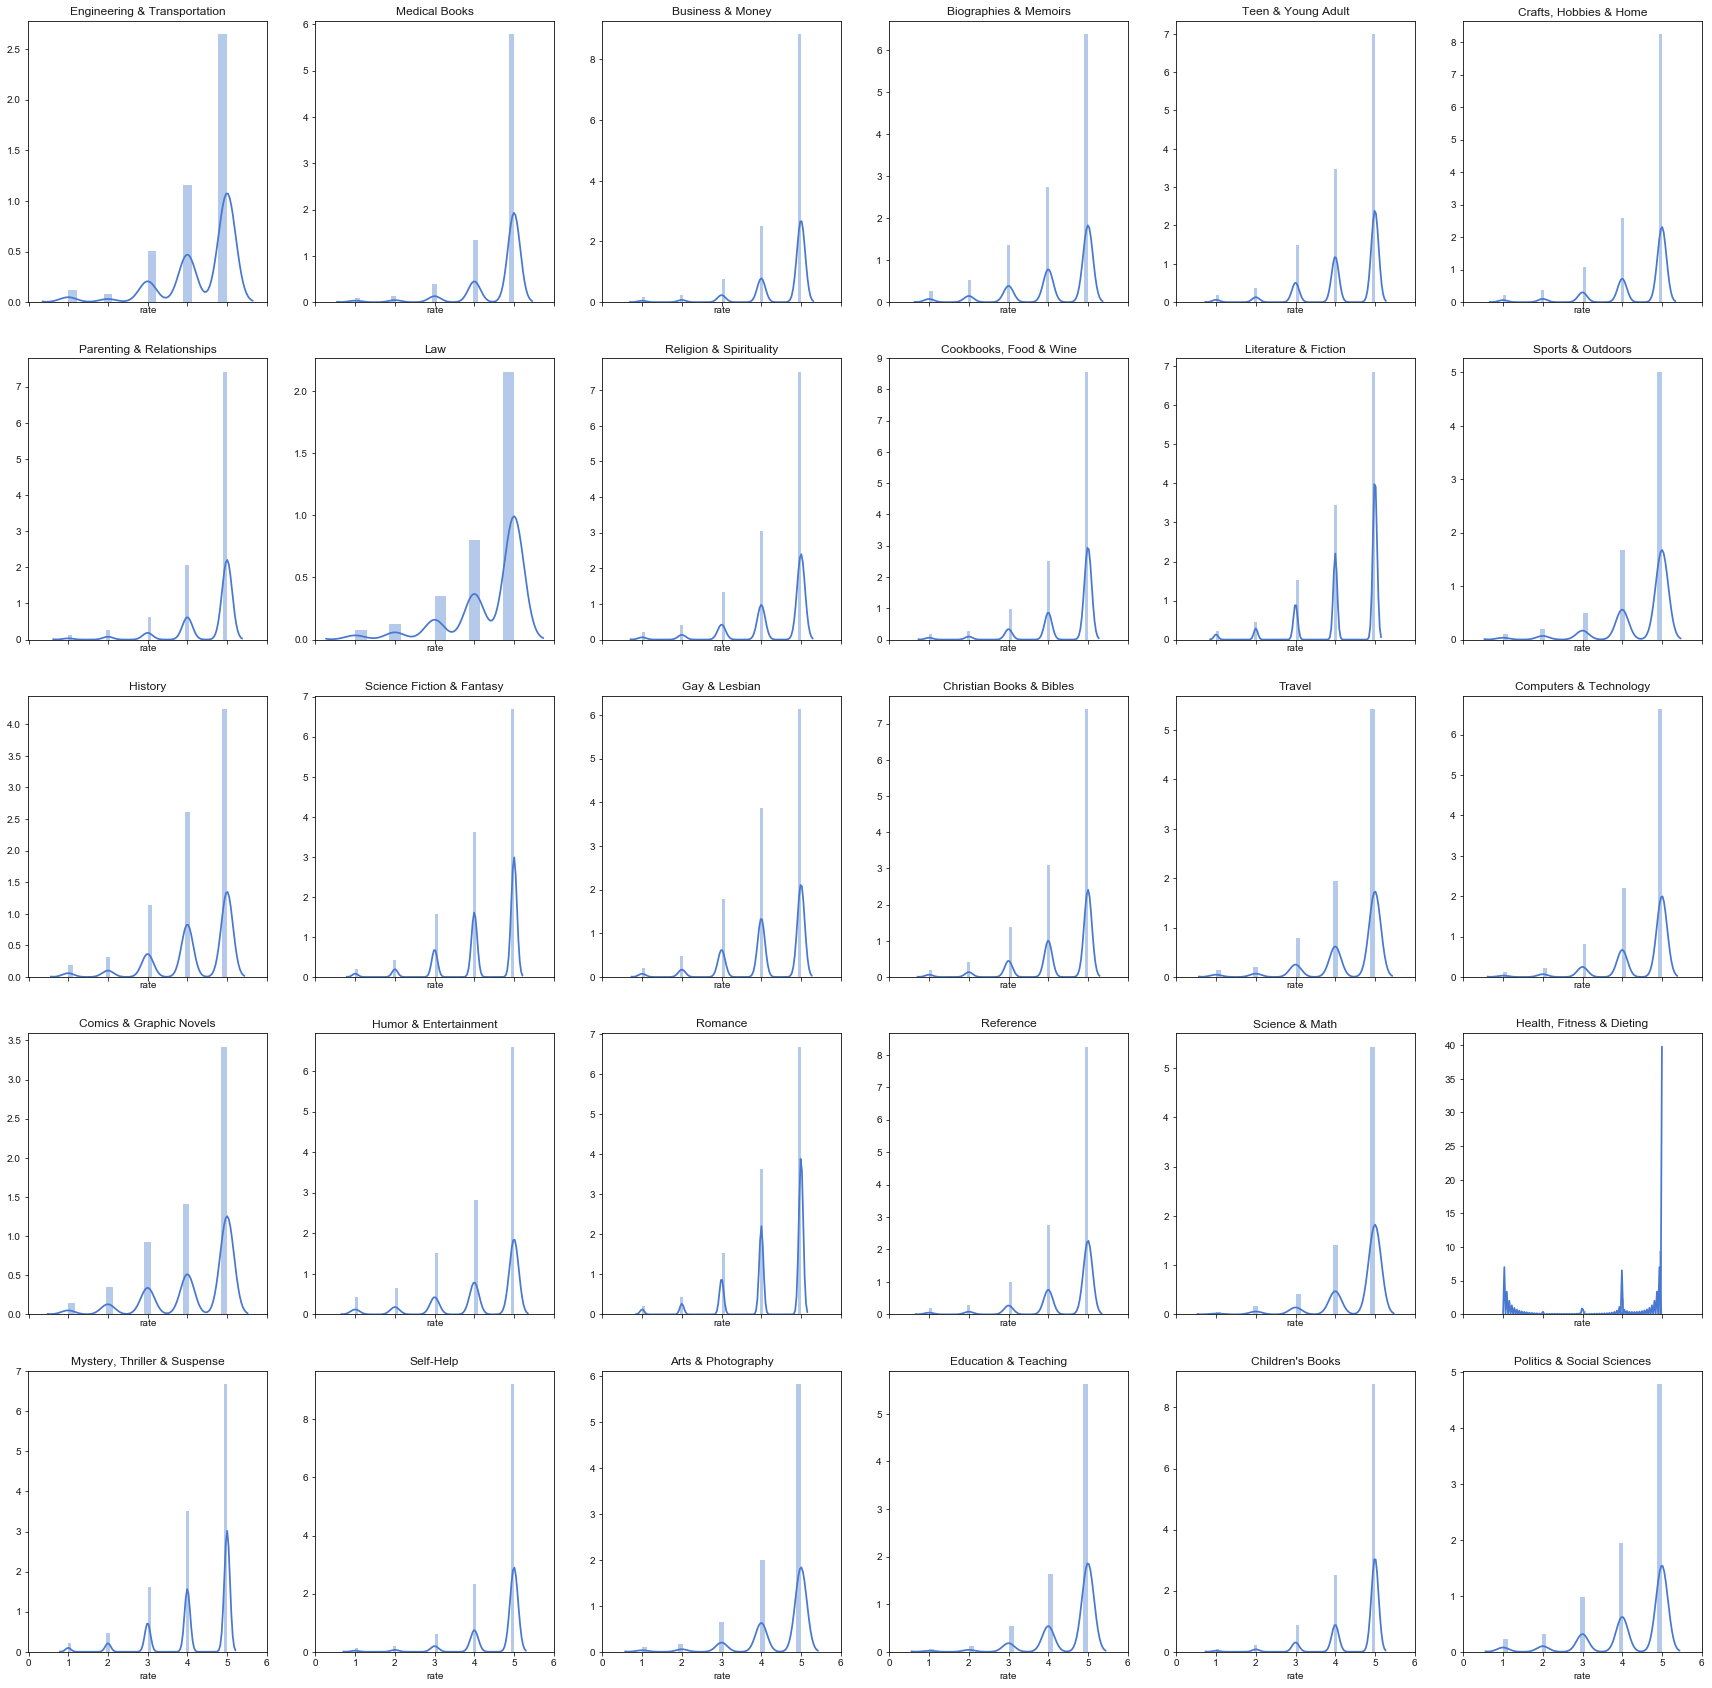

In [46]:
f, axes = plt.subplots(5, 6, figsize=(30,30), sharex=True)
sns.set(style="white", palette="muted", color_codes=True)
for i in range(5):
    for j in range(6):
        axes[i,j].set_title(categories_matrix[i,j])
        sns.distplot(df_kindle_book_review_with_pred[df_kindle_book_review_with_pred.index == categories_matrix[i,j]]['rate'], color="b",ax=axes[i,j])

#### Distribution of difference between real and predictive rating score by category

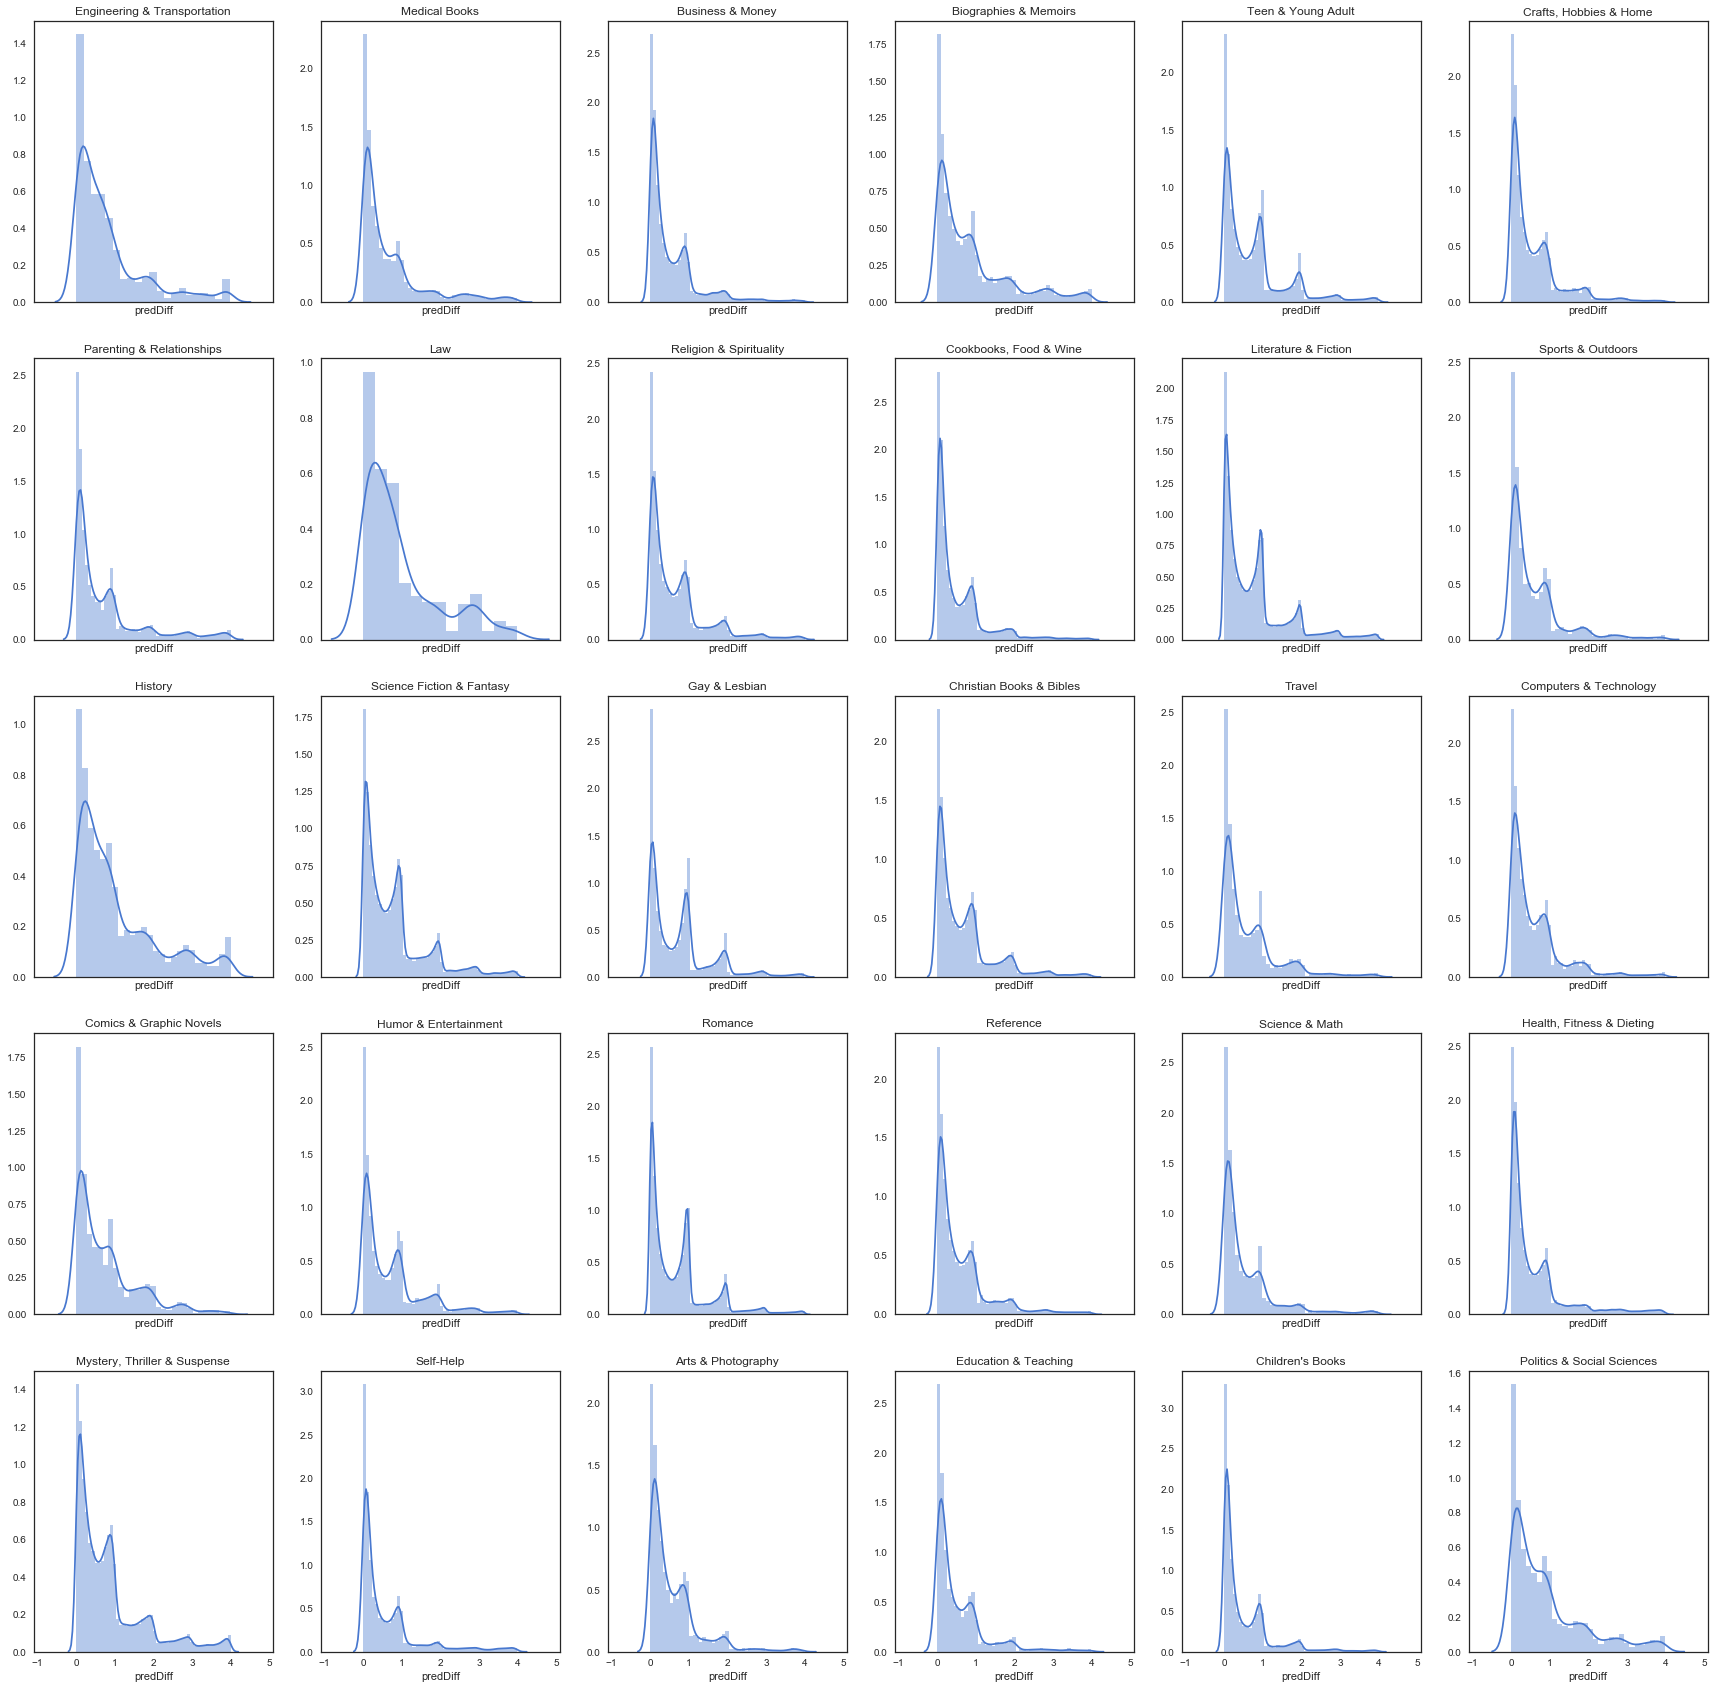

In [47]:
f, axes = plt.subplots(5, 6, figsize=(30,30), sharex=True)
sns.set(style="white", palette="muted", color_codes=True)
for i in range(5):
    for j in range(6):
        axes[i,j].set_title(categories_matrix[i,j])
        sns.distplot(df_kindle_book_review_with_pred[df_kindle_book_review_with_pred.index == categories_matrix[i,j]]['predDiff'], color="b",ax=axes[i,j])

In [48]:
import seaborn as sns
sns.set()

**Volin/Box plot for real v.s. predictive rating score by category**

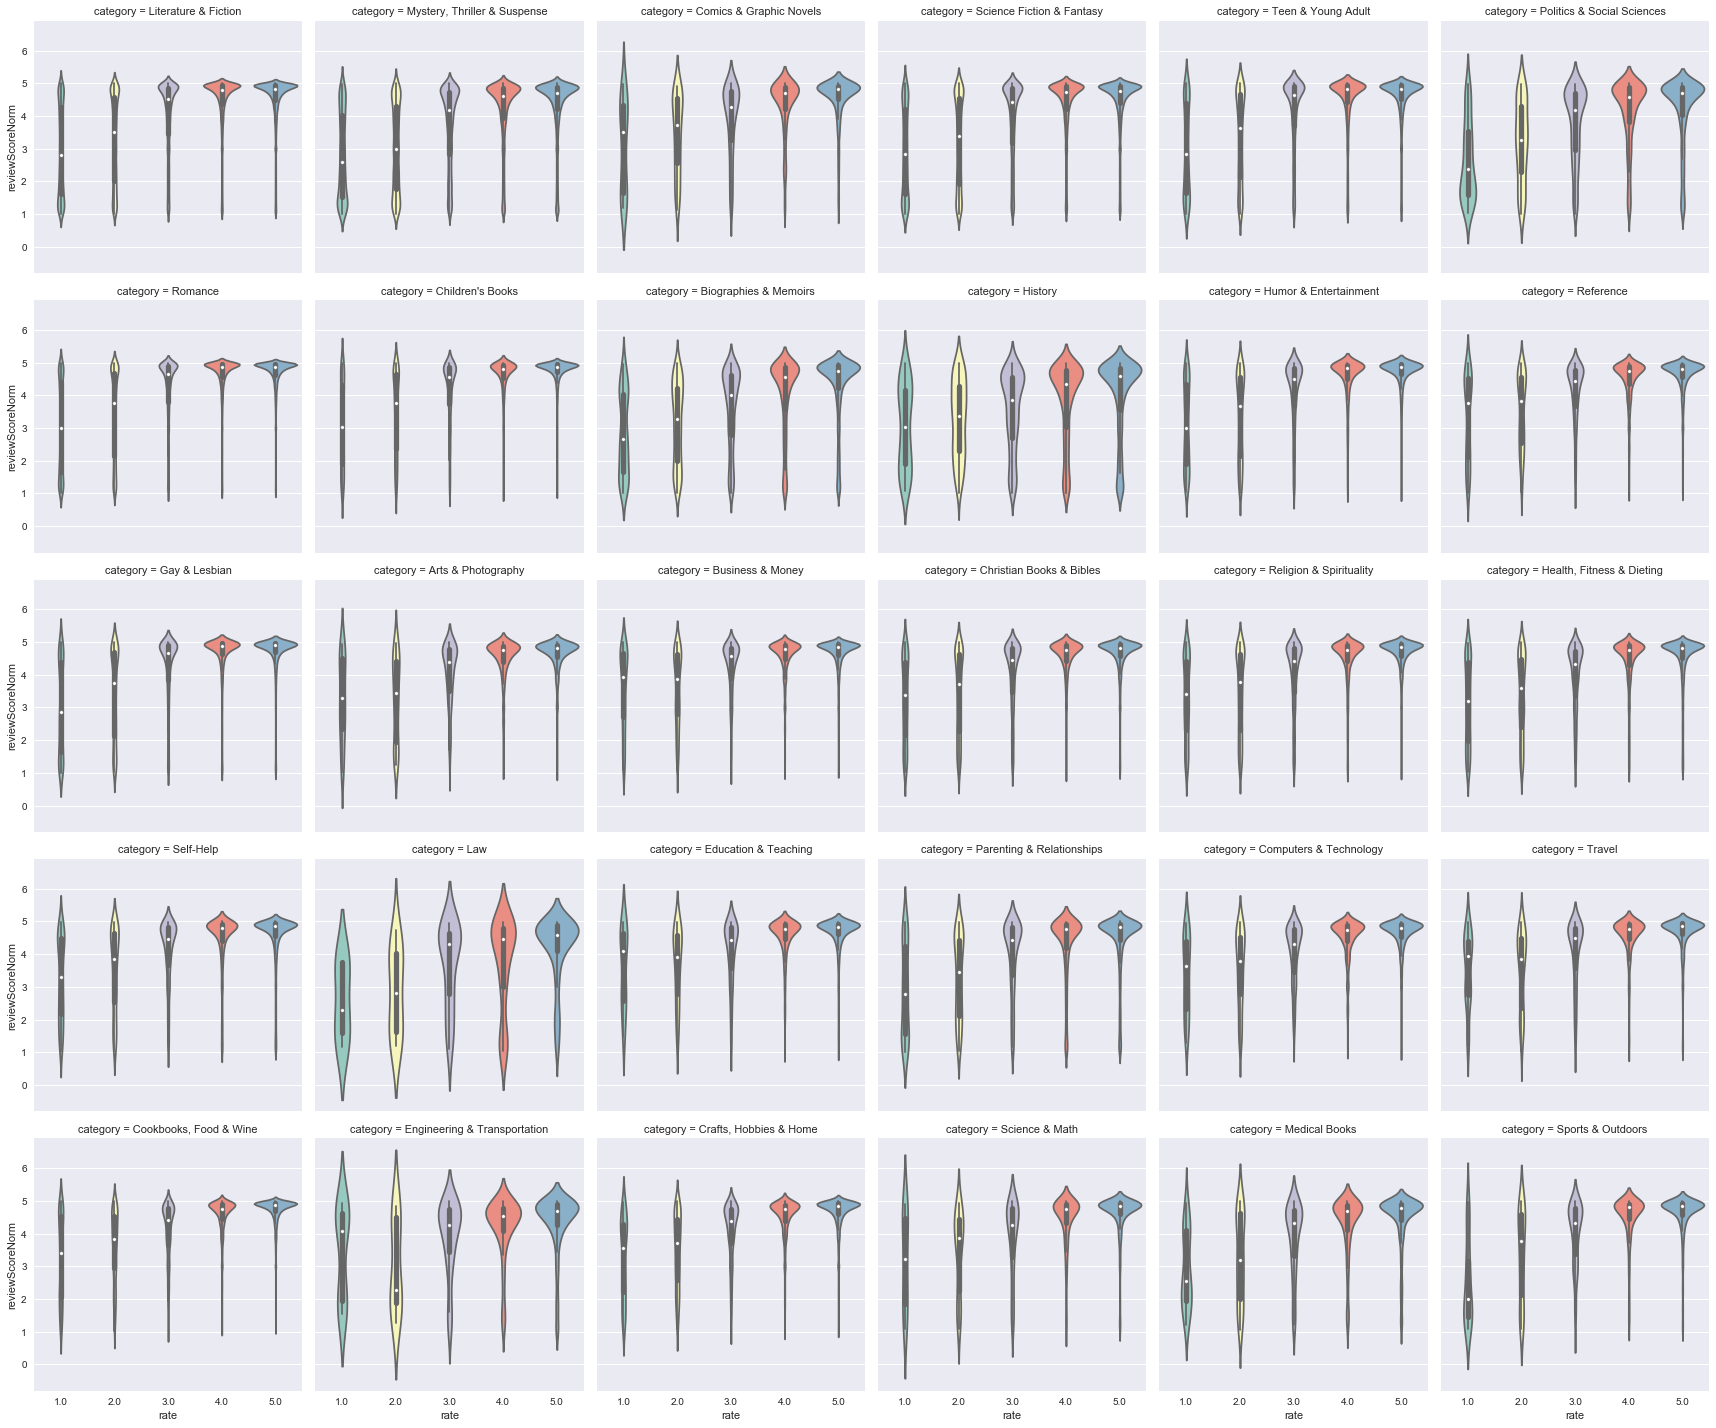

In [51]:
sns.factorplot(x='rate', 
               y='reviewScoreNorm', 
               data=df_kindle_book_review_with_pred.reset_index(), 
               col='category',  
               col_wrap=6,
               kind='violin',
               palette="Set3")

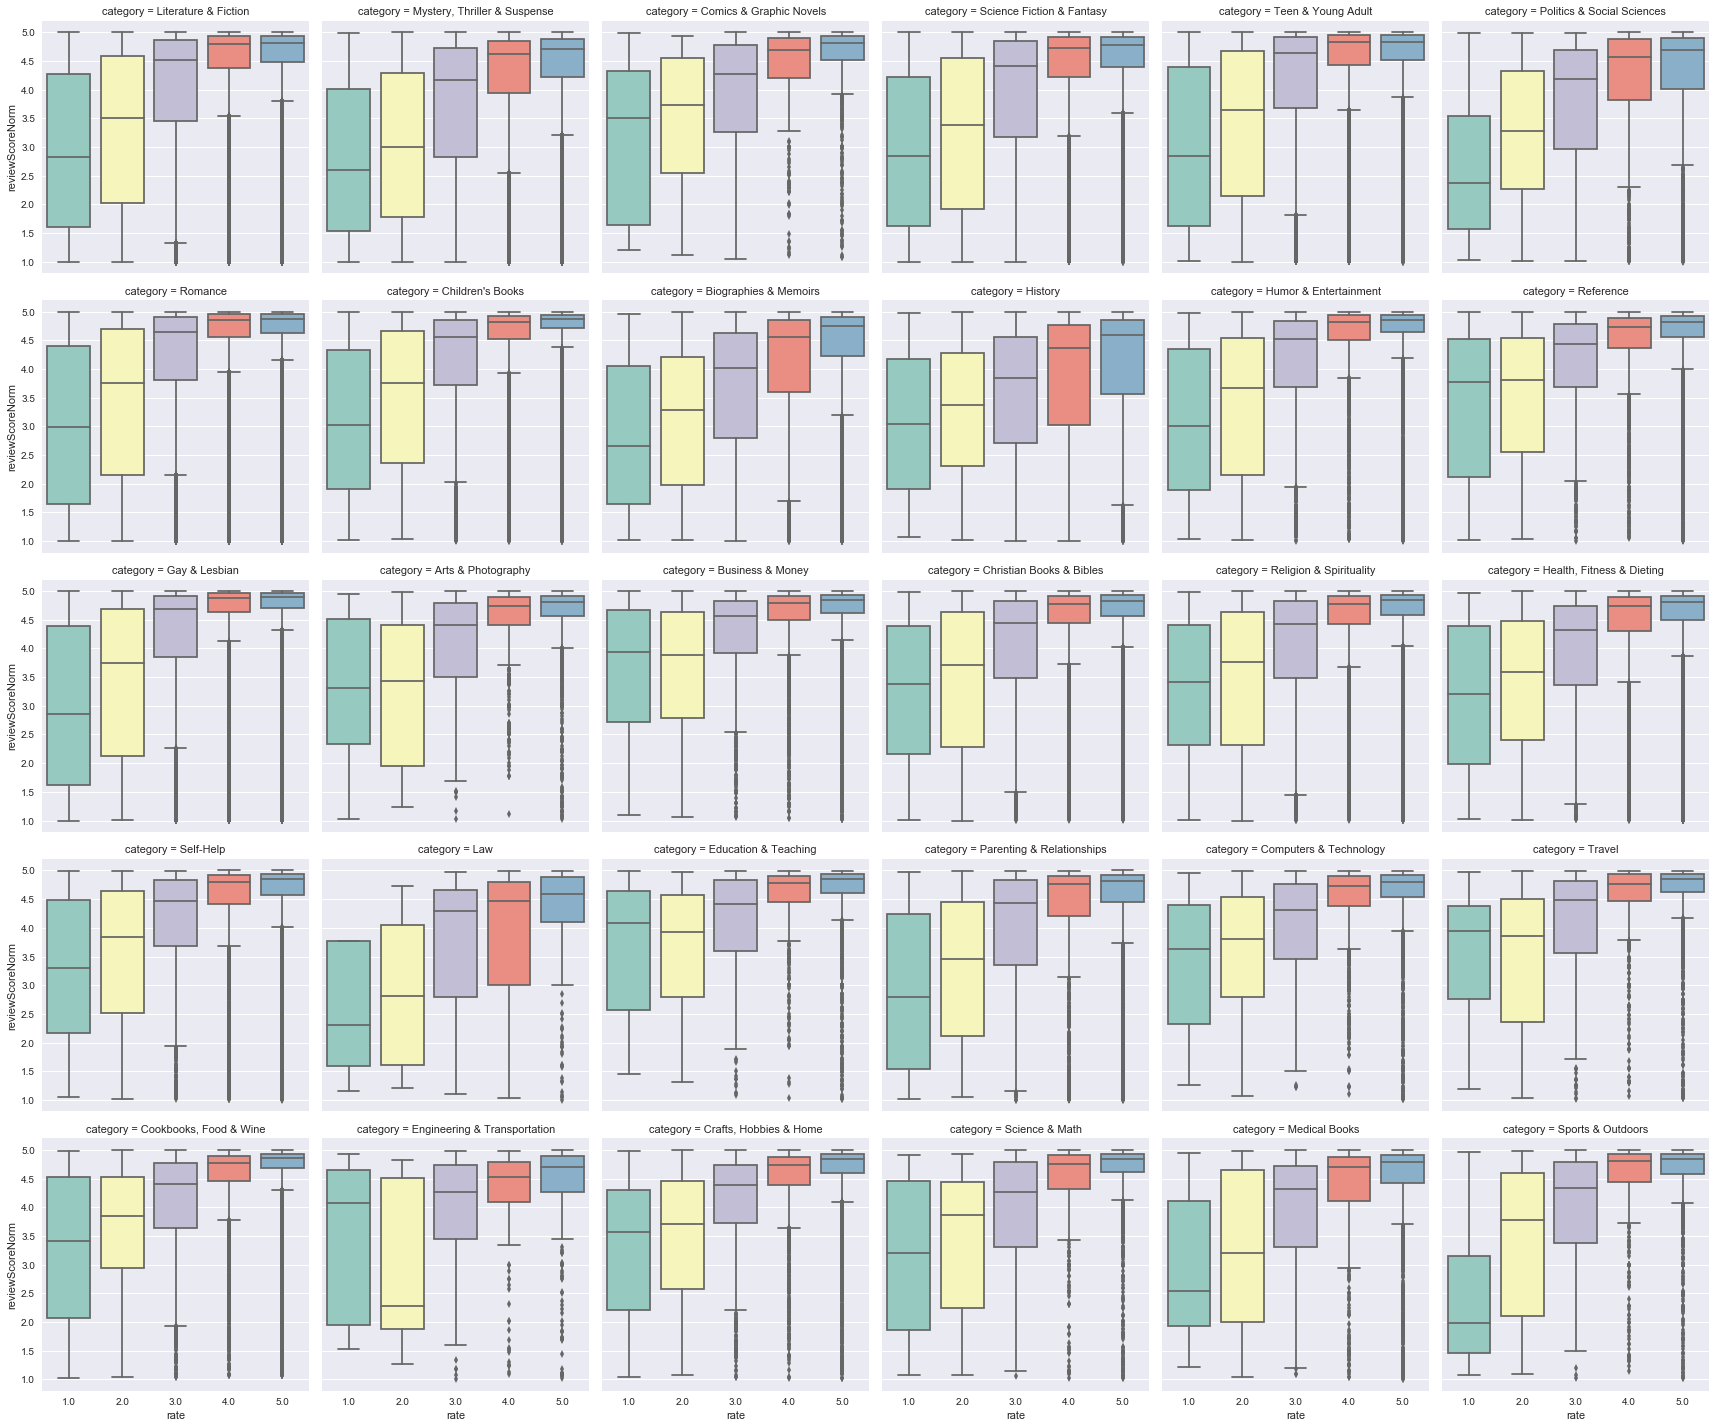

In [52]:
sns.factorplot(x='rate', 
               y='reviewScoreNorm', 
               data=df_kindle_book_review_with_pred.reset_index(), 
               col='category',  
               col_wrap=6,
               kind='box',
               palette="Set3")

**Volin plot for difference by category**

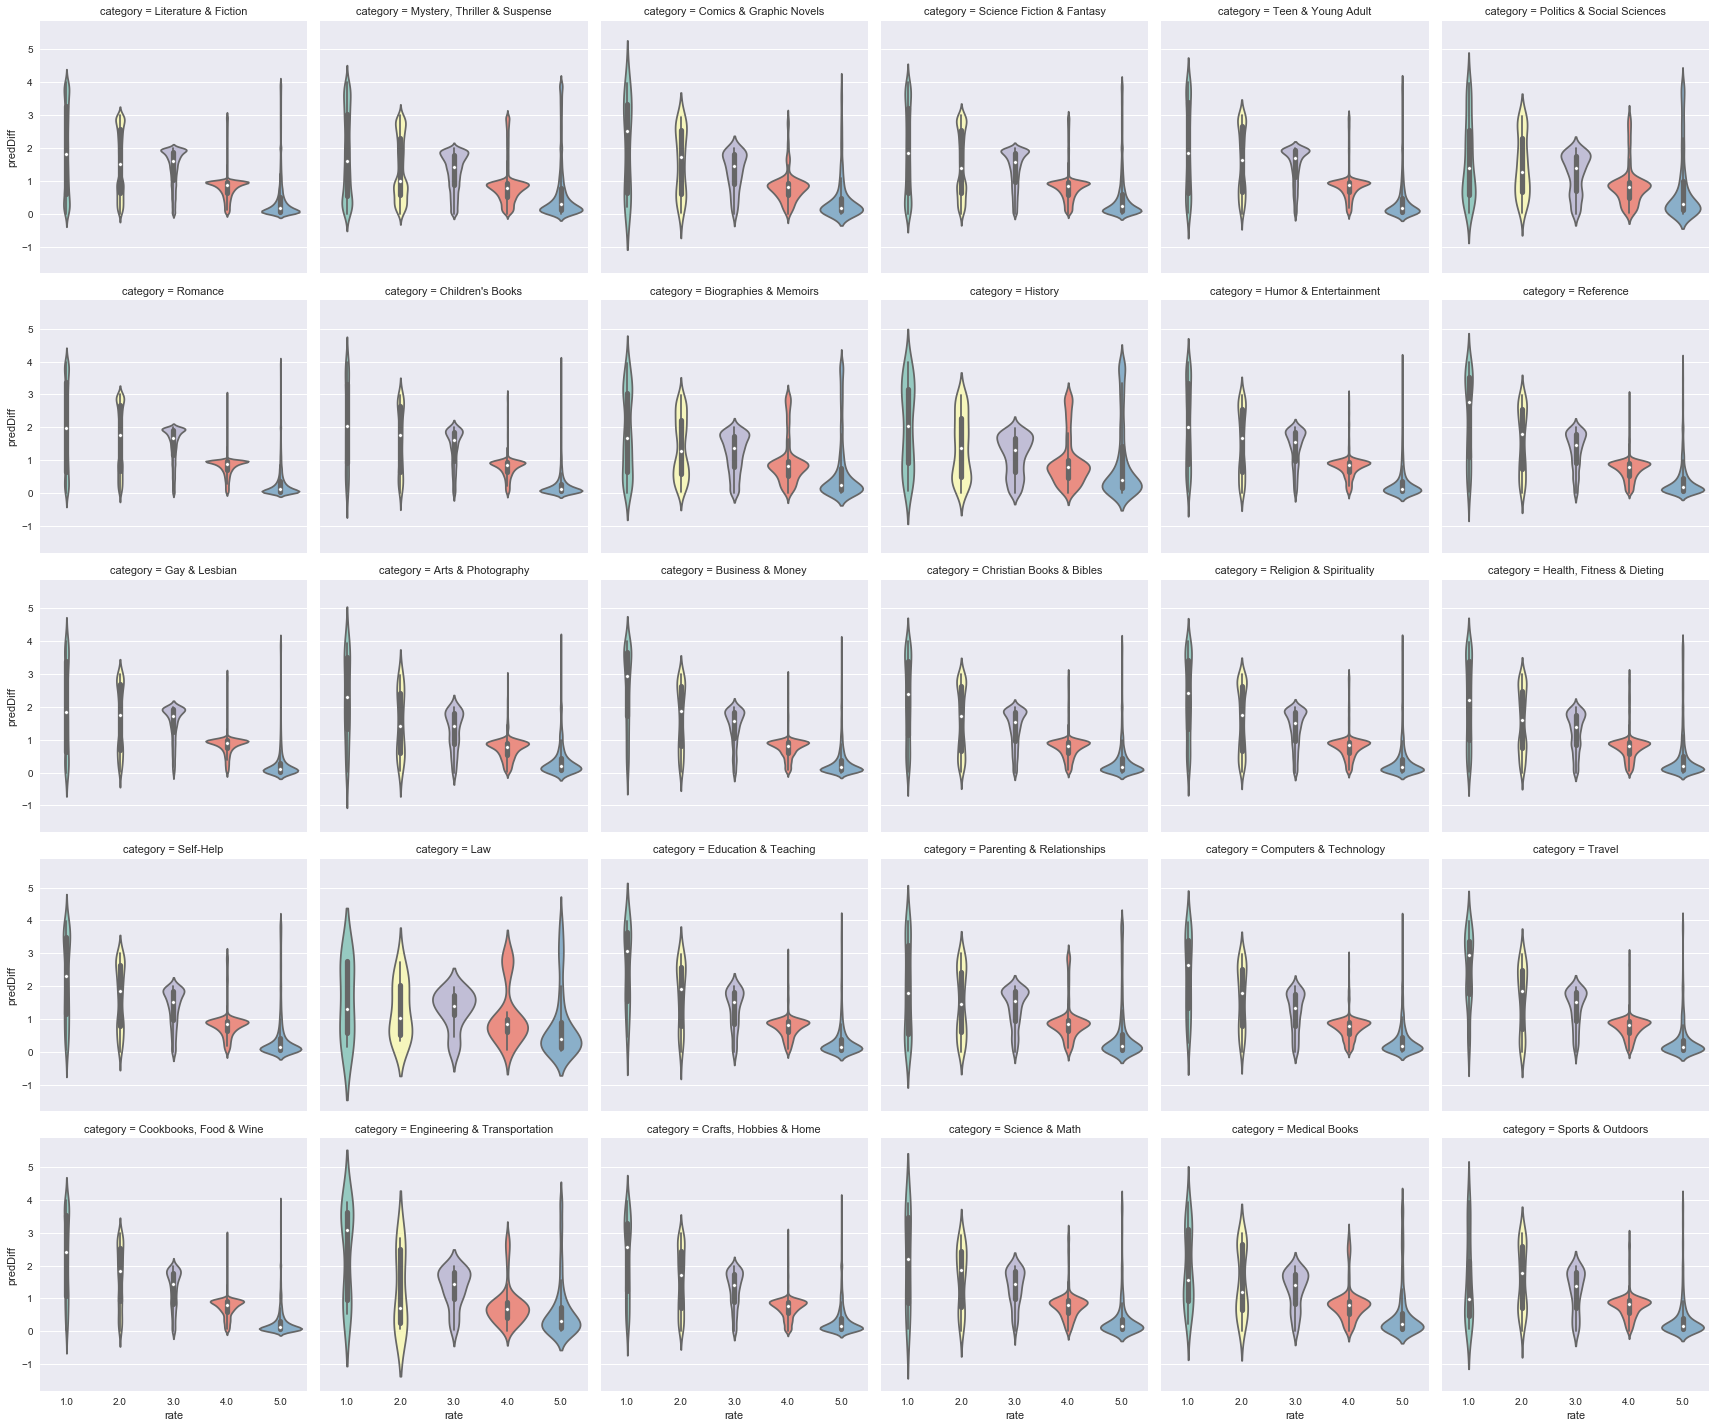

In [53]:
sns.factorplot(x='rate', 
               y='predDiff', 
               data=df_kindle_book_review_with_pred.reset_index(), 
               col='category',  
               col_wrap=6,
               kind='violin',
               palette="Set3")

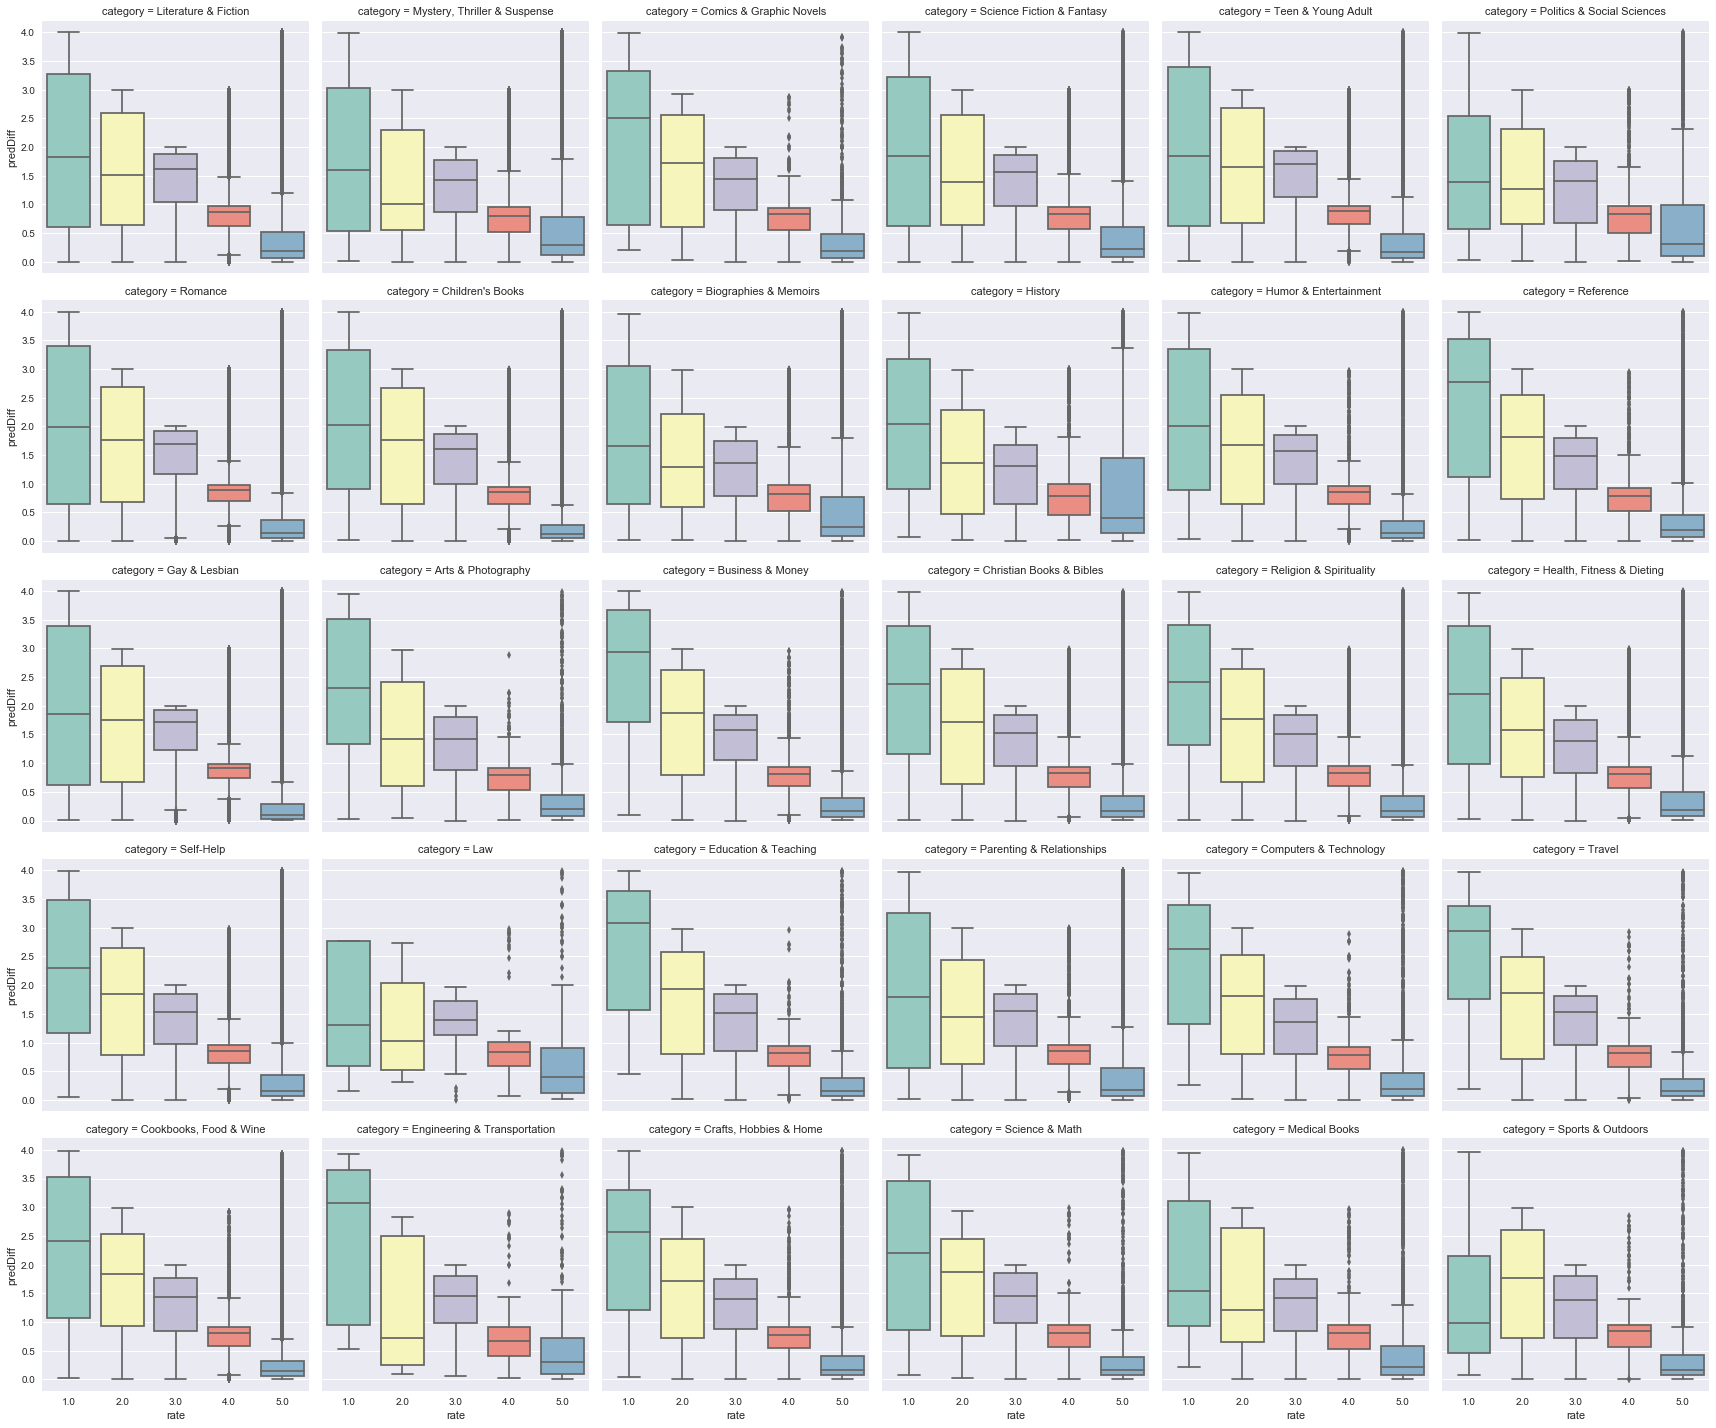

In [54]:
sns.factorplot(x='rate', 
               y='predDiff', 
               data=df_kindle_book_review_with_pred.reset_index(), 
               col='category',  
               col_wrap=6,
               kind='box',
               palette="Set3")

**Relationship between average of real and predicted rating by category**

In [3]:
df_re = pd.DataFrame()
df_re['amount'] = df_kindle_book_review_with_pred.groupby([df_kindle_book_review_with_pred.index])['rate'].count()
df_re['real_avg'] = df_kindle_book_review_with_pred.groupby([df_kindle_book_review_with_pred.index])['rate'].mean()
df_re['pred_avg'] = df_kindle_book_review_with_pred.groupby([df_kindle_book_review_with_pred.index])['reviewScoreNorm'].mean()
df_re.head()

amount  real_avg  pred_avg
category                                            
Arts & Photography          4953  4.516455  4.492526
Biographies & Memoirs      10663  4.282847  4.039775
Business & Money           25907  4.569113  4.556651
Children's Books           51972  4.570730  4.591092
Christian Books & Bibles   33640  4.368252  4.431136

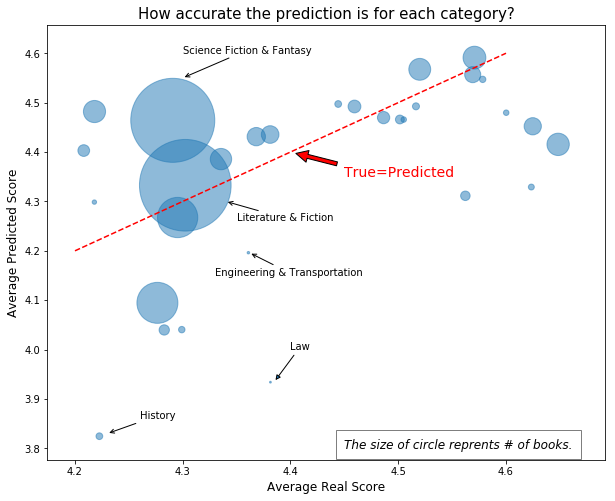

In [4]:
f, ax = plt.subplots(1, 1, figsize=(10,8))
ax.scatter(df_re.real_avg, df_re.pred_avg, s=df_re.amount/100, alpha=0.5)
ax.set_xlabel('Average Real Score',fontdict=dict(size=12))
ax.set_ylabel('Average Predicted Score',fontdict=dict(size=12))
ax.set_title('How accurate the prediction is for each category?',fontdict=dict(size=15))

ax.text(4.45, 3.8, 'The size of circle reprents # of books.', style='oblique', fontdict=dict(size=12),
        bbox={'facecolor':'white', 'alpha':0.5, 'pad':8})


# Plot the line where True Score = Predicted Score
ax.plot([4.2,4.6],[4.2,4.6],'r--')
ax.annotate('True=Predicted', size=14, color='r', xy=(4.4, 4.4), xytext=(4.45, 4.35),
            arrowprops=dict(facecolor='red',shrink=0.1))

# Annotate several categories whose difference between true and predicted scores is huge

# Two categories of the smallest amount
# Law
ax.annotate('Law', size=10, xy=(4.385,3.935), xytext=(4.4, 4),
            arrowprops=dict(arrowstyle='-|>'))

# Engineering & Transportation
ax.annotate('Engineering & Transportation', size=10, xy=(4.362,4.196), xytext=(4.33, 4.15),
            arrowprops=dict(arrowstyle='->'))

# Two categories of the largest amount
# Literature & Fiction
ax.annotate('Literature & Fiction', size=10, xy=(4.34,4.3), xytext=(4.35, 4.26),
            arrowprops=dict(arrowstyle='->'))

# Science Fiction & Fantasy
ax.annotate('Science Fiction & Fantasy', size=10, xy=(4.3,4.55), xytext=(4.3, 4.6),
            arrowprops=dict(arrowstyle='->'))

# History
ax.annotate('History', size=10, xy=(4.23,3.83), xytext=(4.26, 3.86),
            arrowprops=dict(arrowstyle='->'))

plt.show()

**What we have known so far:**
1. We give each review text a sentiment score and normalize it to our 1-5 score as our predicted score, and then we compare it with the real score.
2. From the **Volin/Box plot for real v.s. predictive rating score by category**, we can get that for each category high real score will get a high predicted score. In other words, if someone gives high rate then his/her review is more like to have lots of positive words.
3. From the **Volin/Box plot for difference by category**, we can see the difference between our predicted score and real score is small is the real score is high. But if real score is low, like 1 or 2, then the difference is significant. That is quite interesting and **we can do some extra study on words people use for low score**! One possible reason is the review of people who give low score may not be that *negative* and the words are more netural.
4. From the **Scatterplot**, we see that predicted scores of thoes categories of large amount is more accurate which seems to make sense because we have a larger amount of samples.

#### 3.2.2 More basic study on rating score itself

#### Average rating score by product category

In this part we study the average rating score for each category and sort it to find the 'best' and the 'worst' category.

In [55]:
df_avg_score_by_cat = pd.DataFrame(df_kindle_book_review_with_pred.groupby([df_kindle_book_review_with_pred.index])['rate'].mean())
df_avg_score_by_cat.sort_values(by = ['rate'],ascending = False, inplace = True)

In [56]:
df_avg_score_by_cat.head()

rate
category                           
Health, Fitness & Dieting  4.648391
Self-Help                  4.624832
Medical Books              4.623513
Science & Math             4.600196
Education & Teaching       4.578366

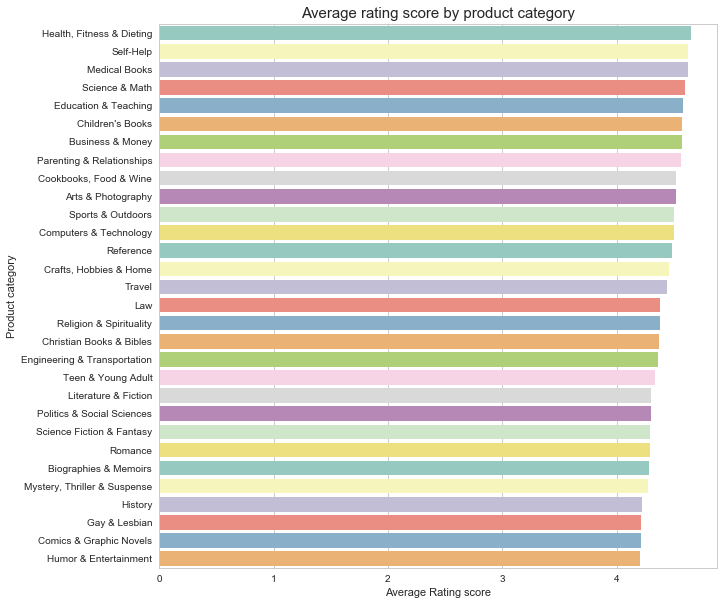

In [65]:
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(10, 10))
sns.set_color_codes("pastel")
sns.barplot(x="rate", y=df_avg_score_by_cat.index, data=df_avg_score_by_cat,palette="Set3")
ax.set(ylabel="Product category", xlabel="Average Rating score")
ax.set_title('Average rating score by product category',size=15)
plt.show()

**What we have known so far:**

Interesting! It seems that books related to health and science all have high score. But books about entertainment are difficult to get that good score.

Can we get the conclusion: More scientific, higher the score is? More fun, lower the score is? It's worth further studying.

**Breakdown of rating score by category**

In this part, we want show the distribution of rating score in each category.

In [67]:
df_rate_count_by_cat = pd.DataFrame(df_kindle_book_review_with_pred.groupby([df_kindle_book_review_with_pred.index,'rate'])['rate'].count())

In [68]:
df_rate_count_by_cat = df_rate_count_by_cat.unstack()
df_rate_count_by_cat.columns = ['1 star','2 stars','3 stars','4 stars','5 stars']
df_rate_count_by_cat.head()

1 star  2 stars  3 stars  4 stars  5 stars
category                                                            
Arts & Photography            60      100      362     1131     3300
Biographies & Memoirs        250      489     1291     2598     6035
Business & Money             330      487     1576     5230    18284
Children's Books             418      942     3648    10516    36448
Christian Books & Bibles     517     1112     3749     8350    19912

In [69]:
df_rate_count_by_cat['sum'] = df_rate_count_by_cat['1 star']+df_rate_count_by_cat['2 stars']+df_rate_count_by_cat['3 stars']+df_rate_count_by_cat['4 stars']+df_rate_count_by_cat['5 stars']

In [70]:
for col in ['1 star','2 stars','3 stars','4 stars','5 stars']:
    df_rate_count_by_cat[col] = df_rate_count_by_cat[col]/df_rate_count_by_cat['sum'] * 100

Sort the categories by the porpotion of 5 star ratings

In [71]:
df_rate_count_by_cat.sort_values(by = ['5 stars'], inplace = True)

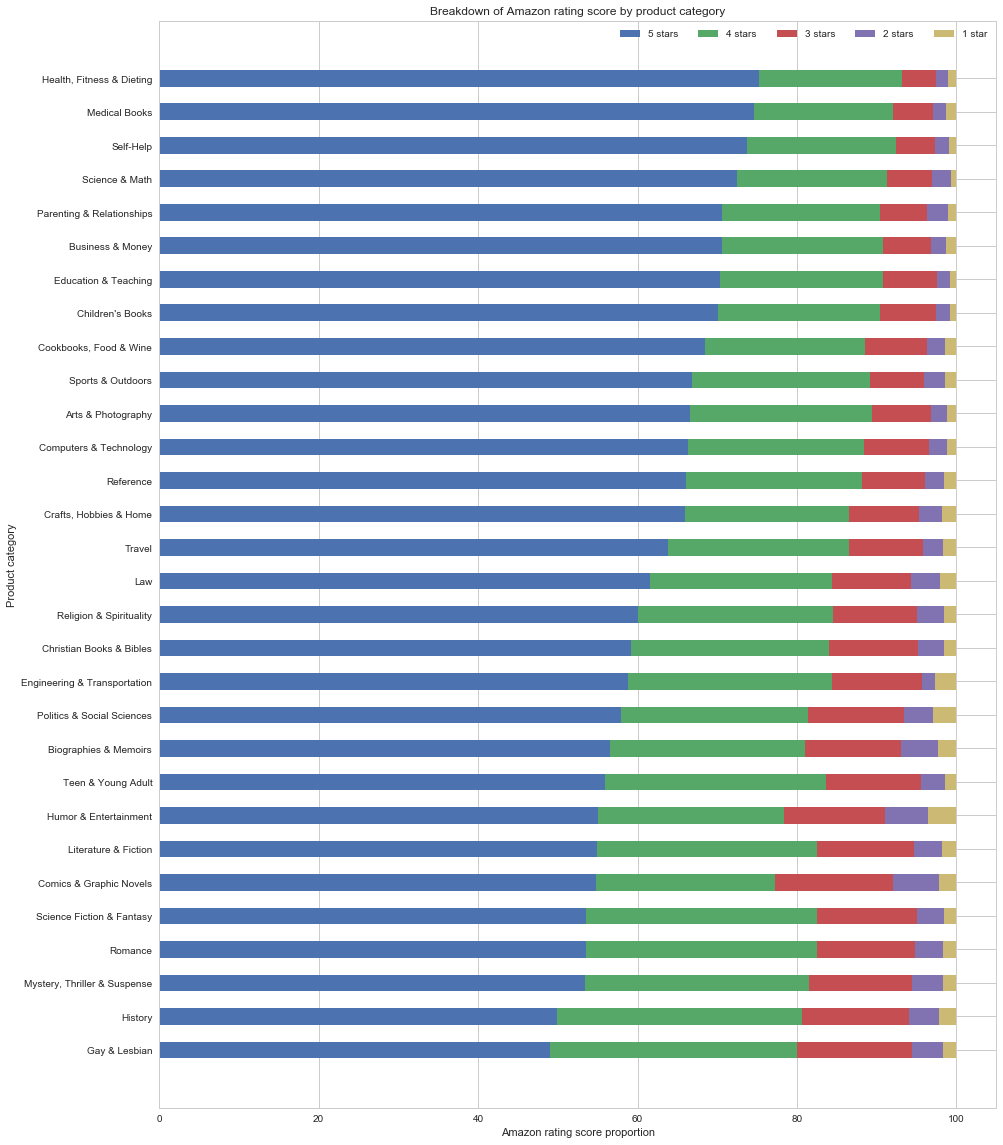

In [80]:
plt.figure(figsize=(15,20))

# The y locations for the groups
ind = np.arange(df_rate_count_by_cat.shape[0])

# The width of the bars: can also be len(x) sequence
width = 0.5       

p1 = plt.barh(ind, df_rate_count_by_cat['5 stars'], width)
p2 = plt.barh(ind, df_rate_count_by_cat['4 stars'], width, left = df_rate_count_by_cat['5 stars'])
p3 = plt.barh(ind, df_rate_count_by_cat['3 stars'], width, left = df_rate_count_by_cat['5 stars'] + df_rate_count_by_cat['4 stars'])
p4 = plt.barh(ind, df_rate_count_by_cat['2 stars'], width, left = df_rate_count_by_cat['5 stars'] + df_rate_count_by_cat['4 stars'] + df_rate_count_by_cat['3 stars'])
p5 = plt.barh(ind, df_rate_count_by_cat['1 star'], width, left = df_rate_count_by_cat['5 stars'] + df_rate_count_by_cat['4 stars'] + df_rate_count_by_cat['3 stars'] + df_rate_count_by_cat['2 stars'])

plt.xlabel('Amazon rating score proportion')
plt.ylabel('Product category')
plt.title('Breakdown of Amazon rating score by product category')
plt.yticks(ind, df_rate_count_by_cat.index, rotation='horizontal')
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), ('5 stars', '4 stars', '3 stars', '2 stars', '1 star'), loc=0, ncol=5)

plt.show()

**What we have known so far:**
1. Most of people love to give 5 star review and only a few reviewer would give 1 star and it is true for each category.
2. **The topic of books somehow influences people's rating?** 

### 3.3 - First look at the difference chronologically

In this part we are going to do some basic analysis on the rating score and find how it changes over time.

In [25]:
df_kindle_book_review['year'] = df_kindle_book_review['unixReviewTime'].apply(lambda x: x.year).values

In [27]:
set(df_kindle_book_review['year'])

{2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014}

Following are the categories we have for some years. Notice that not all categories exist in each year in our dataset.

In [10]:
df_kindle_book_review[df_kindle_book_review['year'] == 2000]['category'].value_counts()

Literature & Fiction            7
Romance                         6
Mystery, Thriller & Suspense    5
Religion & Spirituality         1
Christian Books & Bibles        1
Name: category, dtype: int64

In [11]:
df_kindle_book_review[df_kindle_book_review['year'] == 2005]['category'].value_counts()

Literature & Fiction            50
Romance                         10
Mystery, Thriller & Suspense     7
Name: category, dtype: int64

In [12]:
df_kindle_book_review[df_kindle_book_review['year'] == 2008]['category'].value_counts()

Literature & Fiction            189
Romance                         143
Gay & Lesbian                    23
Mystery, Thriller & Suspense     20
Science Fiction & Fantasy         8
Reference                         8
Religion & Spirituality           1
Humor & Entertainment             1
Arts & Photography                1
Parenting & Relationships         1
Name: category, dtype: int64

In [13]:
df_kindle_book_review[df_kindle_book_review['year'] == 2010]['category'].value_counts()

Literature & Fiction            3729
Romance                         3056
Mystery, Thriller & Suspense    1103
Science Fiction & Fantasy        752
Christian Books & Bibles         567
Gay & Lesbian                    402
Religion & Spirituality          352
Teen & Young Adult               127
Reference                         59
Humor & Entertainment             40
Children's Books                  35
Biographies & Memoirs             26
Self-Help                         25
Parenting & Relationships         23
Computers & Technology            17
Health, Fitness & Dieting         11
Politics & Social Sciences        10
History                            7
Comics & Graphic Novels            7
Travel                             6
Cookbooks, Food & Wine             6
Arts & Photography                 5
Science & Math                     3
Sports & Outdoors                  3
Business & Money                   1
Law                                1
Name: category, dtype: int64

**Annual difference on average score**

In [5]:
df_kindle_book_review_with_pred['year'] = df_kindle_book_review_with_pred['unixReviewTime'].apply(lambda x: x.year)

In [6]:
df_avg_score_by_year = pd.DataFrame(df_kindle_book_review_with_pred.groupby(['year'])['rate'].mean())

In [7]:
df_amount_by_year = pd.DataFrame(df_kindle_book_review_with_pred.groupby(['year'])['rate'].count())

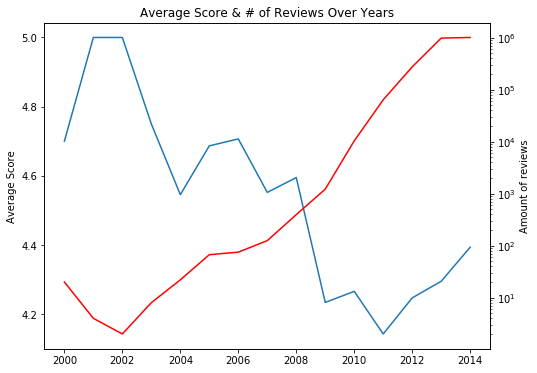

In [8]:
fig = plt.figure(figsize=(8,6))

# Average Score over year
ax1 = fig.add_subplot(111)
ax1.plot(df_avg_score_by_year)
plt.ylabel("Average Score")
plt.grid(axis='y',b='False')

# Amount of reviews over year
ax2 = ax1.twinx()
plt.semilogy(df_amount_by_year,'r')
plt.ylabel('Amount of reviews')
plt.grid(axis='y',b='False')

plt.title('Average Score & # of Reviews Over Years')
plt.show()

**Annual breakdown of score**

In [83]:
df_rate_count_by_year = pd.DataFrame(df_kindle_book_review_with_pred.groupby(['year','rate'])['rate'].count())

In [84]:
df_rate_count_by_year = df_rate_count_by_year.unstack()
df_rate_count_by_year.columns = ['1 star','2 stars','3 stars','4 stars','5 stars']
df_rate_count_by_year = df_rate_count_by_year.fillna(0)
df_rate_count_by_year

1 star  2 stars   3 stars   4 stars   5 stars
year                                                
2000      0.0      0.0       0.0       6.0      14.0
2001      0.0      0.0       0.0       0.0       4.0
2002      0.0      0.0       0.0       0.0       2.0
2003      0.0      0.0       0.0       2.0       6.0
2004      0.0      0.0       1.0       8.0      13.0
2005      0.0      0.0       0.0      21.0      46.0
2006      0.0      0.0       5.0      12.0      58.0
2007      0.0      0.0      10.0      36.0      79.0
2008      0.0      4.0      26.0      96.0     269.0
2009     21.0     55.0     158.0     372.0     617.0
2010    194.0    425.0    1244.0    3076.0    5434.0
2011   1849.0   3225.0    9318.0   19197.0   30448.0
2012   5562.0  10752.0   36173.0   80351.0  142333.0
2013  16367.0  35193.0  123845.0  275556.0  533832.0
2014  14809.0  30024.0  102689.0  259296.0  605591.0

In [85]:
df_rate_count_09_14 = df_rate_count_by_year.loc[2009:]
df_rate_count_09_14['sum'] = list(df_rate_count_09_14.sum(axis = 1))

In [86]:
for col in ['1 star','2 stars','3 stars','4 stars','5 stars']:
    df_rate_count_09_14[col] = df_rate_count_09_14[col]/df_rate_count_09_14['sum'] * 100

In [87]:
df_rate_count_09_14

1 star   2 stars    3 stars    4 stars    5 stars        sum
year                                                                
2009  1.717089  4.497138  12.919052  30.417007  50.449714     1223.0
2010  1.870240  4.097175  11.992673  29.653909  52.386002    10373.0
2011  2.887393  5.036151  14.550963  29.977981  47.547512    64037.0
2012  2.021289  3.907388  13.145644  29.200388  51.725291   275171.0
2013  1.661974  3.573644  12.575739  27.981109  54.207534   984793.0
2014  1.462749  2.965600  10.143035  25.611783  59.816833  1012409.0

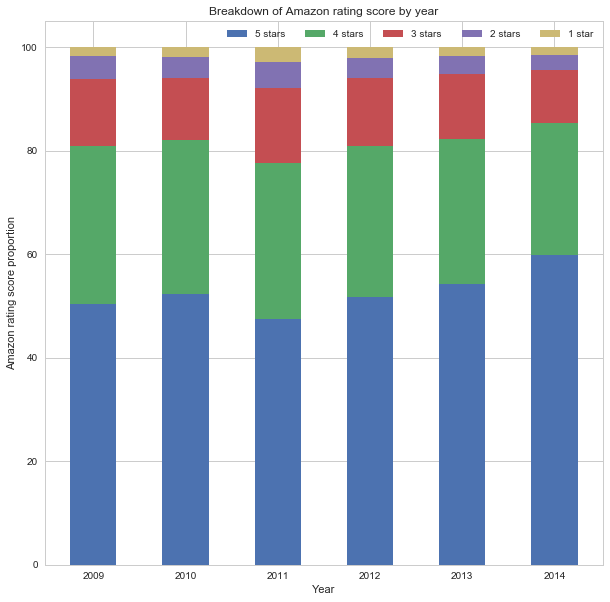

In [124]:
plt.figure(figsize=(10,10))

# The y locations for the groups
ind = np.arange(df_rate_count_09_14.shape[0])

# The width of the bars: can also be len(x) sequence
width = 0.5      

p1 = plt.bar(ind, df_rate_count_09_14['5 stars'], width)
p2 = plt.bar(ind, df_rate_count_09_14['4 stars'], width, bottom = df_rate_count_09_14['5 stars'])
p3 = plt.bar(ind, df_rate_count_09_14['3 stars'], width, bottom = df_rate_count_09_14['5 stars'] + df_rate_count_09_14['4 stars'])
p4 = plt.bar(ind, df_rate_count_09_14['2 stars'], width, bottom = df_rate_count_09_14['5 stars'] + df_rate_count_09_14['4 stars'] + df_rate_count_09_14['3 stars'])
p5 = plt.bar(ind, df_rate_count_09_14['1 star'], width, bottom = df_rate_count_09_14['5 stars'] + df_rate_count_09_14['4 stars'] + df_rate_count_09_14['3 stars'] + df_rate_count_09_14['2 stars'])

plt.ylabel('Amazon rating score proportion')
plt.xlabel('Year')
plt.title('Breakdown of Amazon rating score by year')
plt.xticks(ind, df_rate_count_09_14.index, rotation='horizontal')
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), ('5 stars', '4 stars', '3 stars', '2 stars', '1 star'), loc=0,ncol=5)

plt.show()

**What we have known so far:**
1. The amount of data before 2009 is very small.
2. For average rating, the score of years before 2009 is meaningless. If we only consider rating score before 2009, we can see that the average rating goes higher every year.
3. For breakdown of scores, we merge the year before 2009 together. From the stacked plot, we can see that the distribution doesn't change much. Most of people give high socre. But recently more and more people give 5 stars which explains why the average rating goes higher recently.

### 3.4 Review text analysis -- Key word study

In this part, we want find out what's the key words for each category and for each year

**Defination of key word**: 

The most frequently used words (Only **Nouns** and **Adjectives**) in the reviews.

**Method of finding**:

That's where Natural Language Processing comes into play.

We are going to use [NLTK](http://www.nltk.org) to find Nouns and Adjectives and calulate the frequency of words in the lists of text.

1. Remove punctuations from the string.
2. Transform all forms of words into original form, e.g. transform 'went' and 'gone' into 'go' using `WordNetLemmatizer` from NLTK.
3. Select only nouns and adjectives using `word_tokenize` and `pos_tag` from NLTK.
4. Calculate the frequency of the words with the help of WordCloud.

**Visulization**:

We choose to use [Word Cloud](https://en.wikipedia.org/wiki/Tag_cloud) for visualization. 

As defined in Wikipedia:

>A tag cloud (word cloud, or weighted list in visual design) is a visual representation of text data, typically used to depict keyword metadata (tags) on websites, or to visualize free form text.

>This format is useful for quickly perceiving the most prominent terms and for locating a term alphabetically to determine its relative prominence.

And [wordcloud](https://github.com/amueller/word_cloud) is a little word cloud generator in Python.

In [16]:
import random
from matplotlib import animation
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud,ImageColorGenerator,STOPWORDS
from scipy.misc import imread

Define the function about words processing.

Function `replacePunctuation`  is used to remove all the punctuation in a string.

In [2]:
def replacePunctuation(line):
    line = line.lower()
    for ch in line:
        if ch in "~@#$%^!^&*()_+-<>?,.:;{}[]|\'`""":
            line = line.replace(ch," ")
    return line

Function `originalword` is used to convert an inflected form into a lemma.   
Here we only care about noun and adjective since keywords are usually noun or adjective.

In [3]:
def originalword(line):
    line_split = line.split()
    for word in line_split:
        words = WordNetLemmatizer().lemmatize(word,'n')
        words = WordNetLemmatizer().lemmatize(words,'a')
        line = line.replace(word,words)
    return line

Function `textprocessing` is used to select review from input data, remove all the punctuation and choose only **nouns** and **adjectives** from the data.

In [4]:
def textprocessing(x):
    X = []
    for i in range (len(x)):
        review = x[i].reviewText.values
        X.append(str(review))
    word_type = ['NN','NNS','NNP','NNPS','JJ','JJR','JJS']
    for i in range(len(X)):
        tokens = nltk.word_tokenize(X[i])
        tagged = nltk.pos_tag(tokens)
        Y =[]
        for word_list in tagged:
            for w_type in word_type:
                if word_list[1]==w_type:
                    Y.append(word_list[0])
        Y =" ".join(list(Y))
        X[i] = originalword(replacePunctuation(Y))
    return X

Inputing review data, `df_kindle_book` is the data of book, and `df_kindle_sr` is the data of short reads.

In [7]:
df_kindle_book = pd.read_pickle('pickleDataNew/kindle_book_review.pkl')
df_kindle_sr = pd.read_pickle('pickleDataNew/kindle_short_read_review.pkl')

### For each year

Setting `unixReviewTime` as index in order to divide data by time. 

In [8]:
df_book = df_kindle_book.drop_duplicates(["reviewText"])
df_sr = df_kindle_sr.drop_duplicates(["reviewText"])
book = df_book.set_index('unixReviewTime')
sr = df_sr.set_index('unixReviewTime')

Using `groupby` to group the data and store each group in the list.

In [9]:
data_book= []
data_sr = []
for name, group in book.groupby(pd.TimeGrouper(freq='A')):
    data_book.append(group)
for name, group in sr.groupby(pd.TimeGrouper(freq='A')):
    data_sr.append(group)

Using `textprocessing` fuction to process the review data.

In [11]:
review_book = textprocessing(data_book)
review_sr = textprocessing(data_sr)

The masks for visualizaton for each year.

In [18]:
name_book = ["2000.jpg","2001.jpg","2002.jpg","2003.jpg","2004.jpg","2005.jpg","2006.jpg","2007.jpg","2008.jpg","2009.jpg","2010.jpg","2011.jpg","2012.jpg","2013.jpg","2014.jpg"]
name_sr = ["2007.jpg","2008.jpg","2009.jpg","2010.jpg","2011.jpg","2012.jpg","2013.jpg","2014.jpg"]

Below, we use [WordCloud](https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html) function to creat word cloud for review data.   

#### Wordcloud for reviews of books

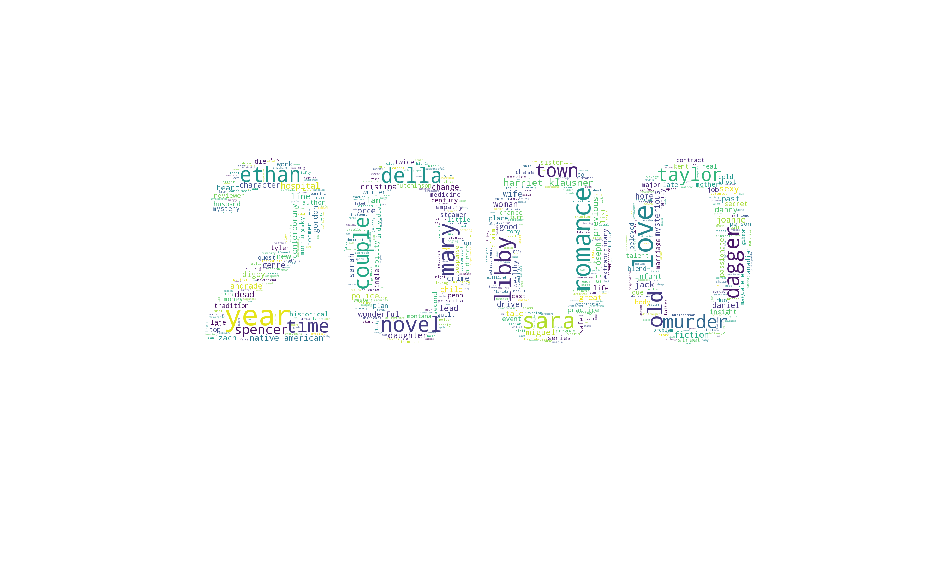

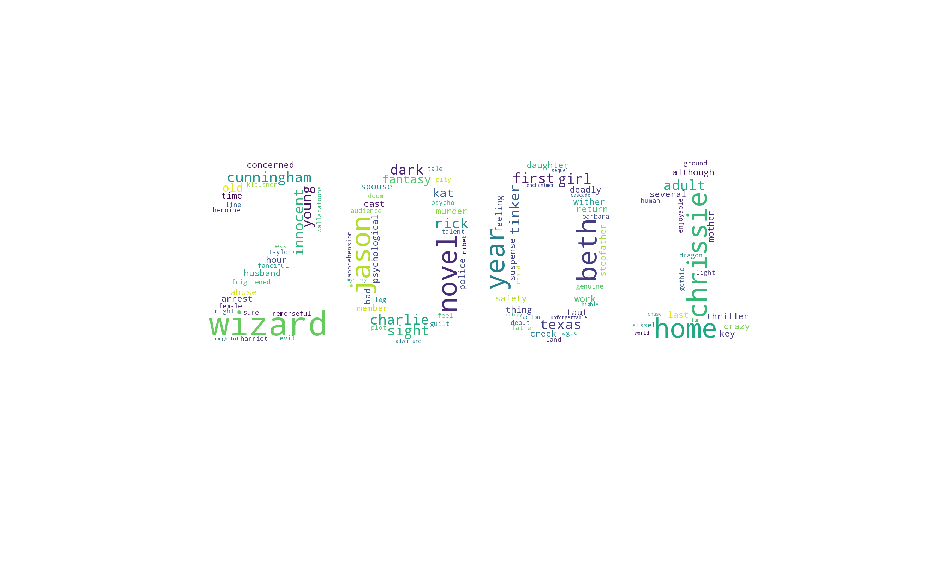

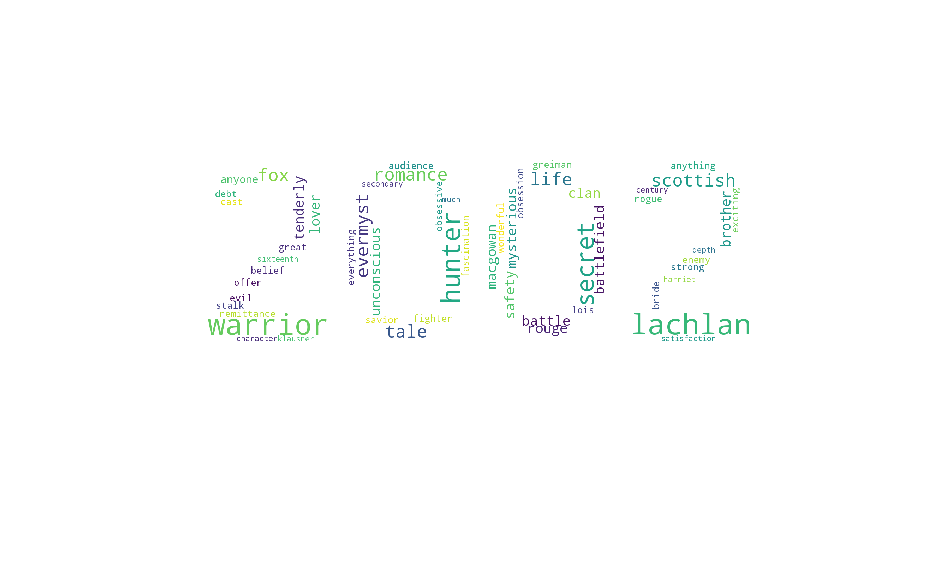

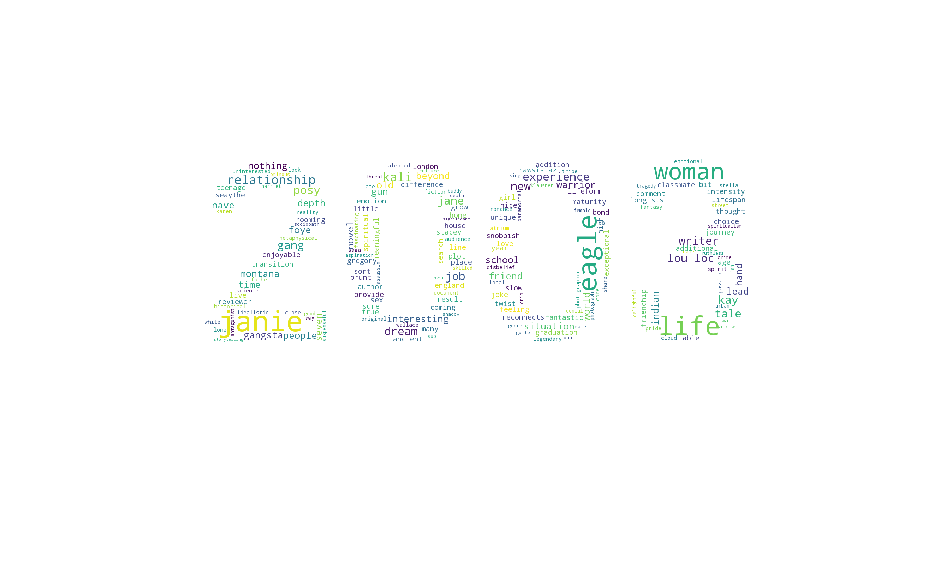

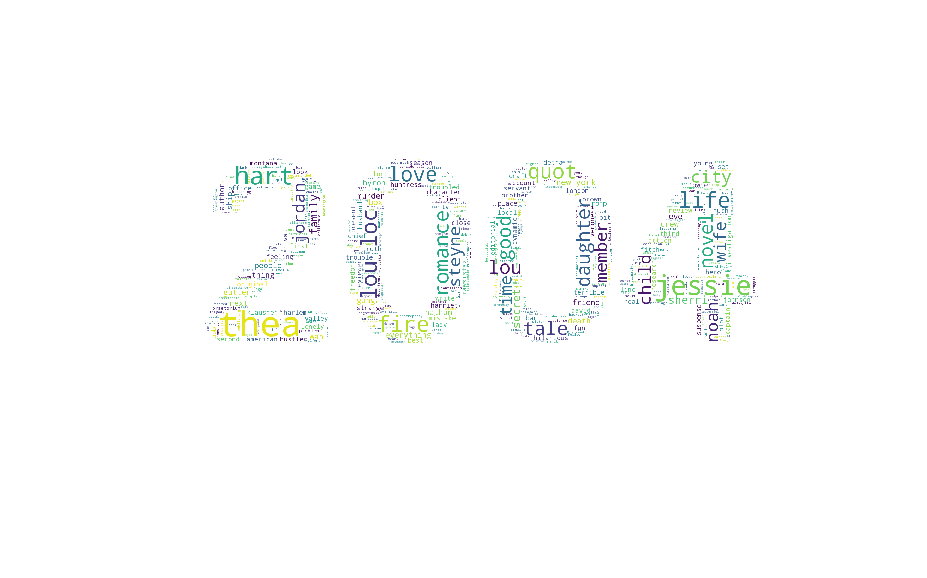

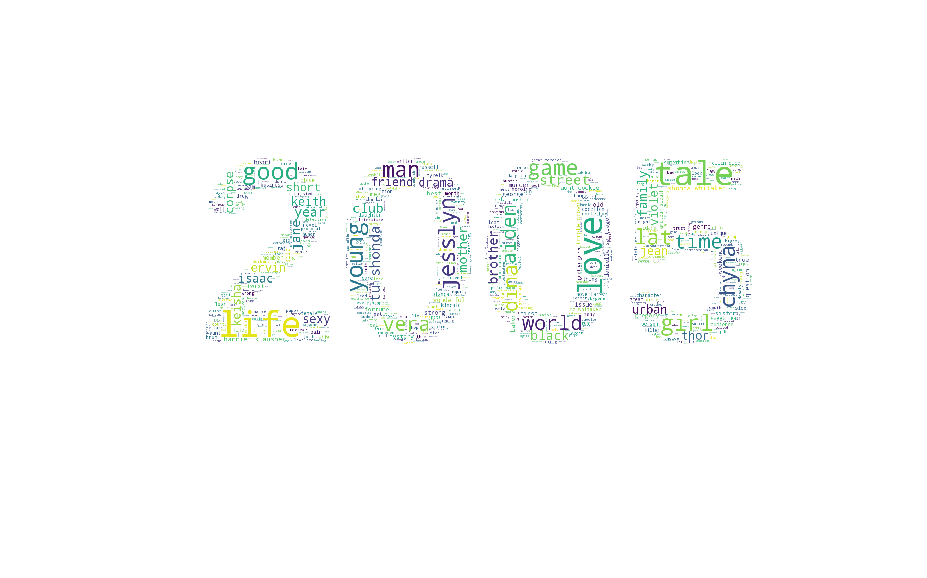

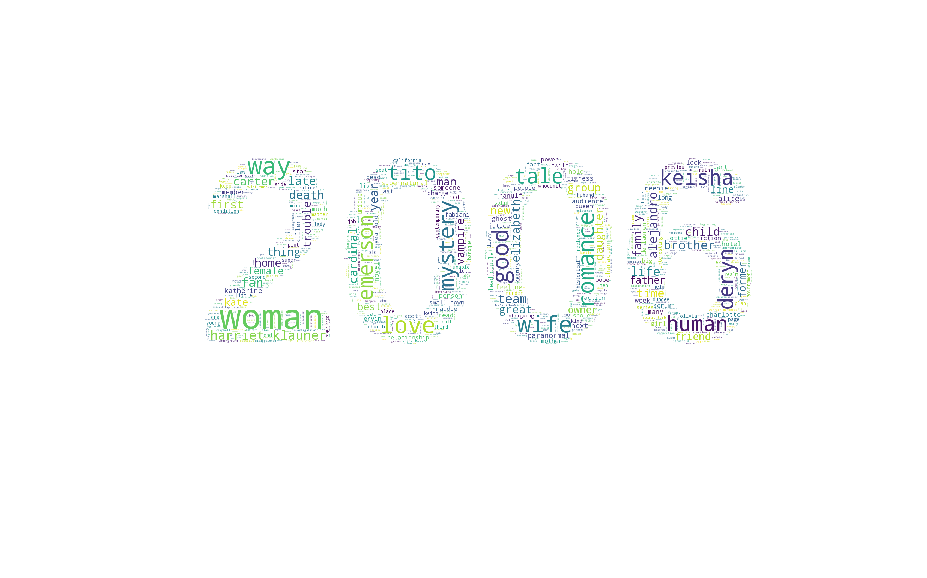

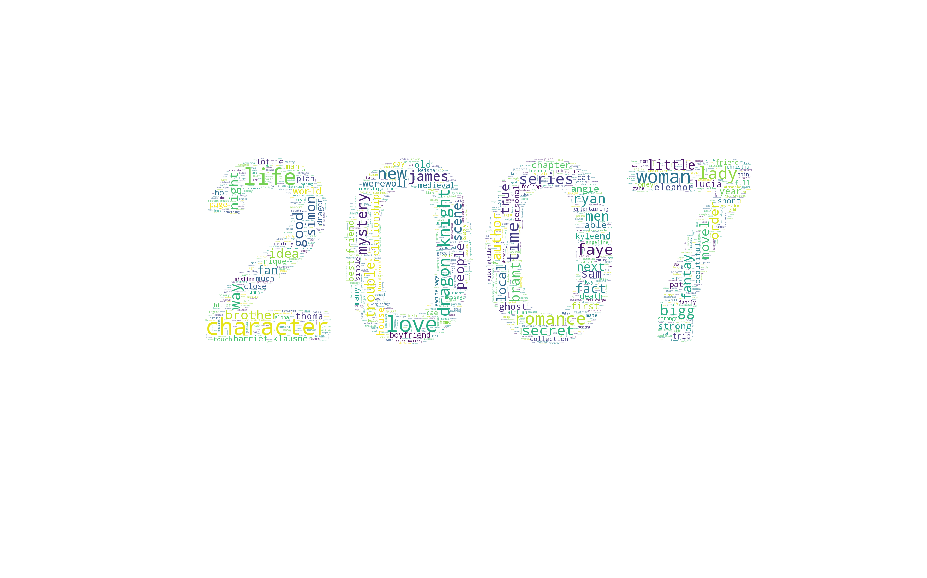

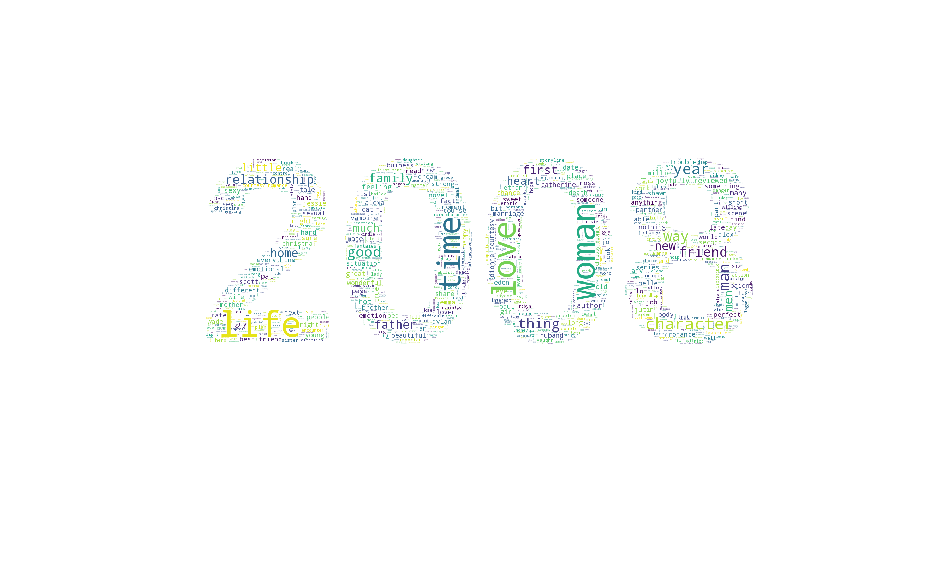

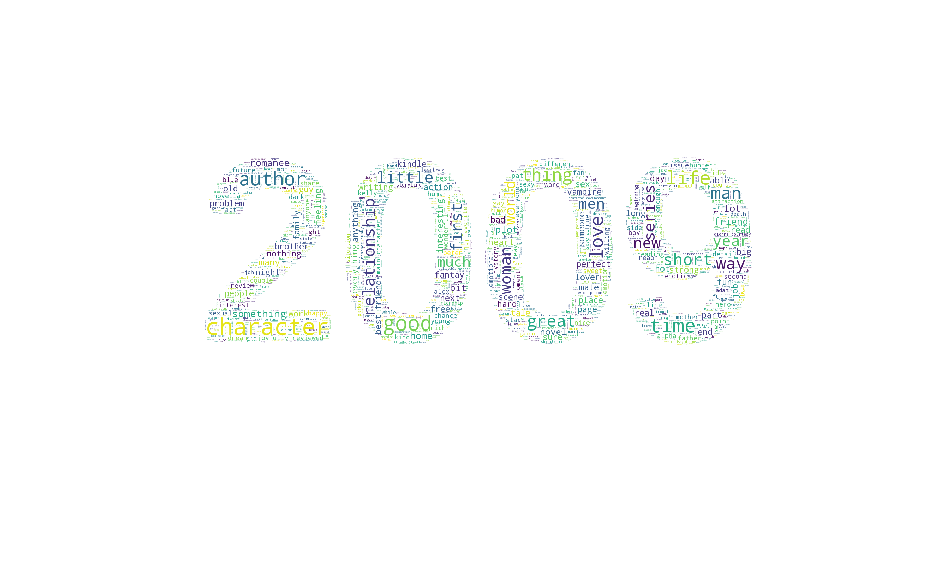

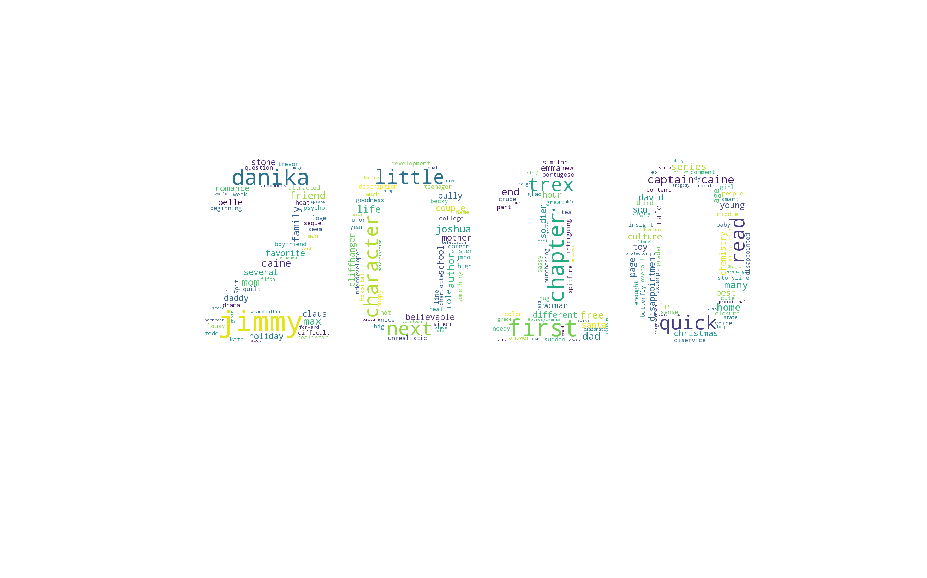

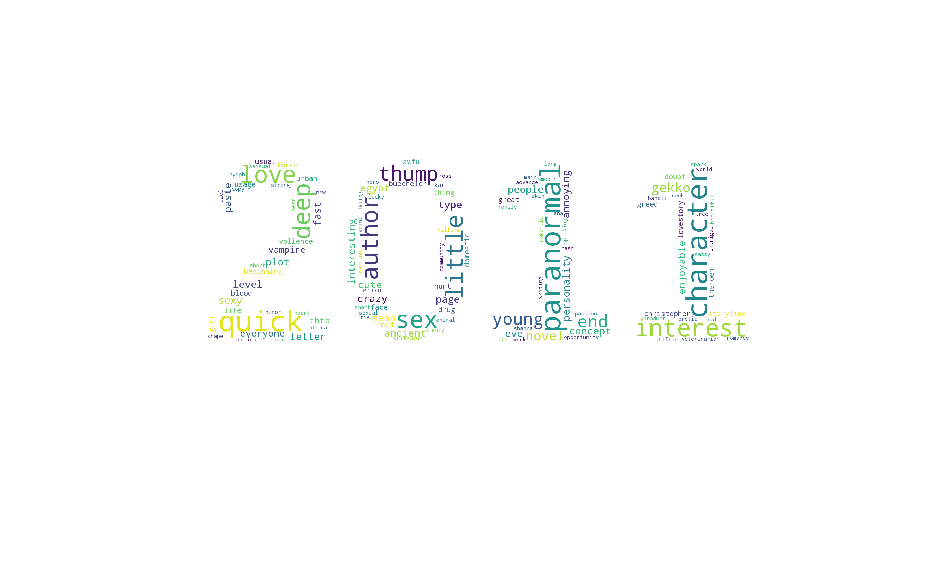

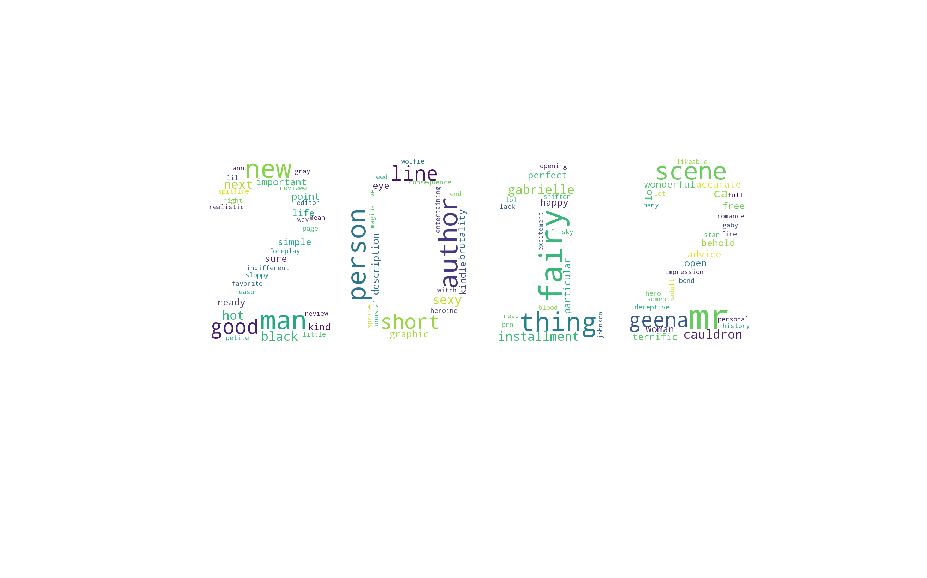

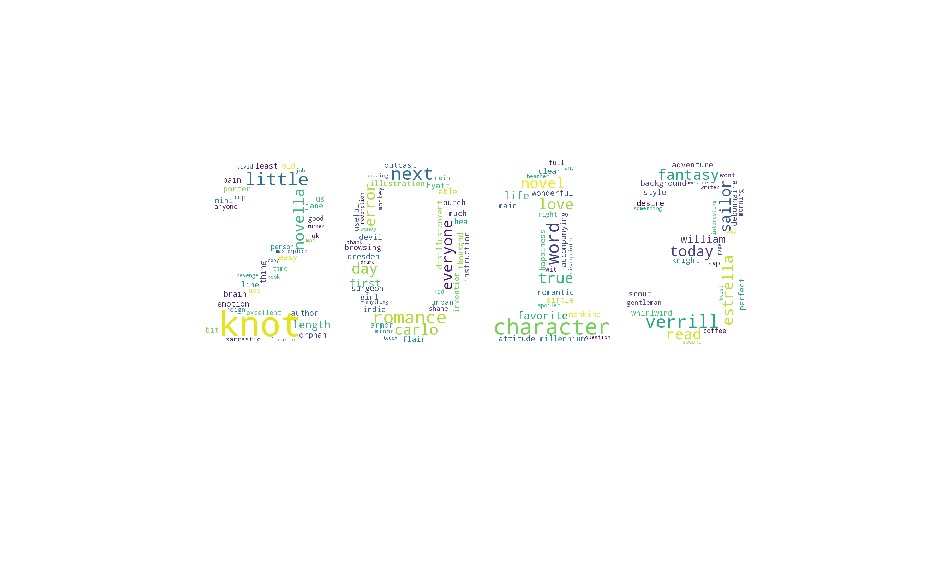

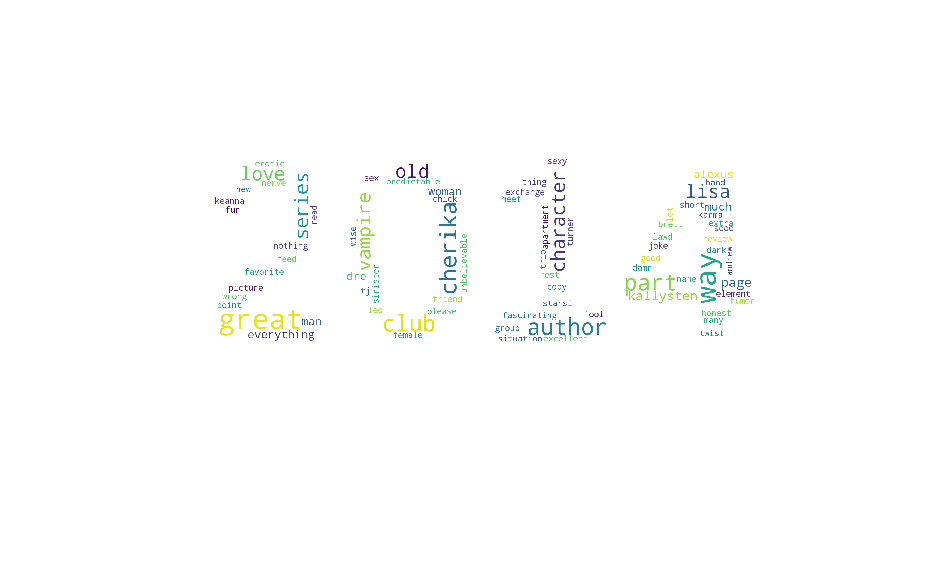

In [20]:
del_word = ['book','story','will','one','two','three','four','five','want','make','take','reader']
for word in del_word:
    stopword = STOPWORDS.add(word)
for i in range(len(name_book)):
    picture = imread('img/' + name_book[i])
    wordcloud = WordCloud(background_color="white",mask=picture,stopwords=stopword,max_words=2000,max_font_size=400,random_state=43).generate(review_book[i])
    image_colors = ImageColorGenerator(picture)
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

#### Wordcloud for reviews of shortreads

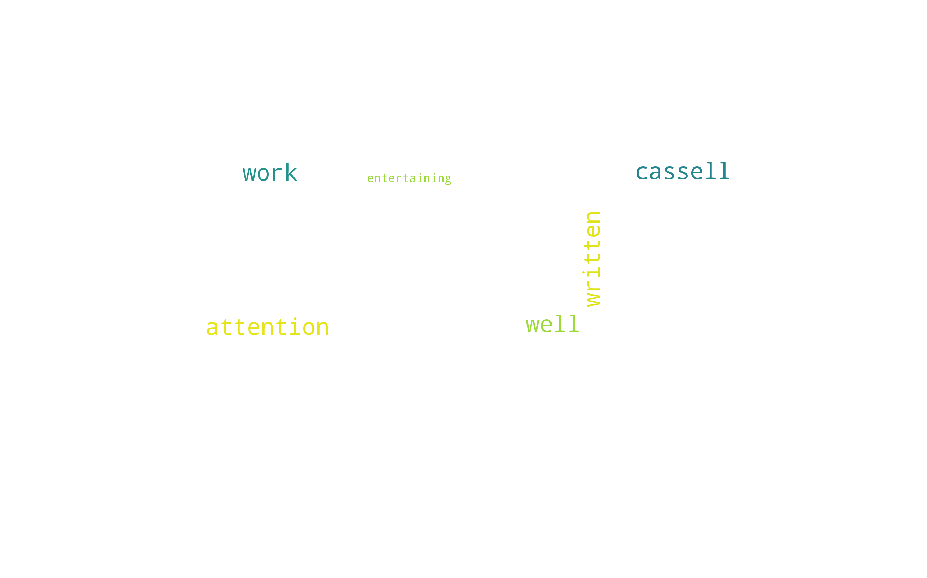

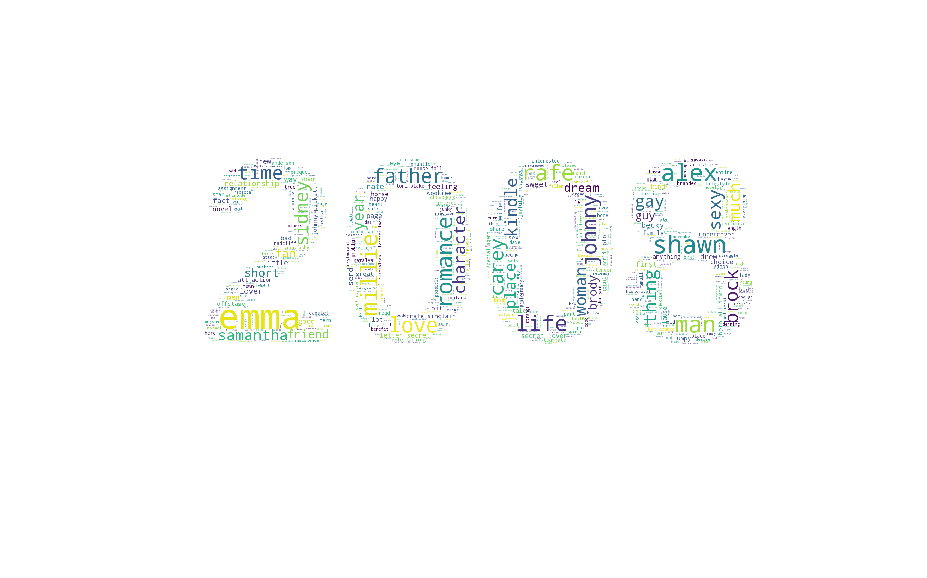

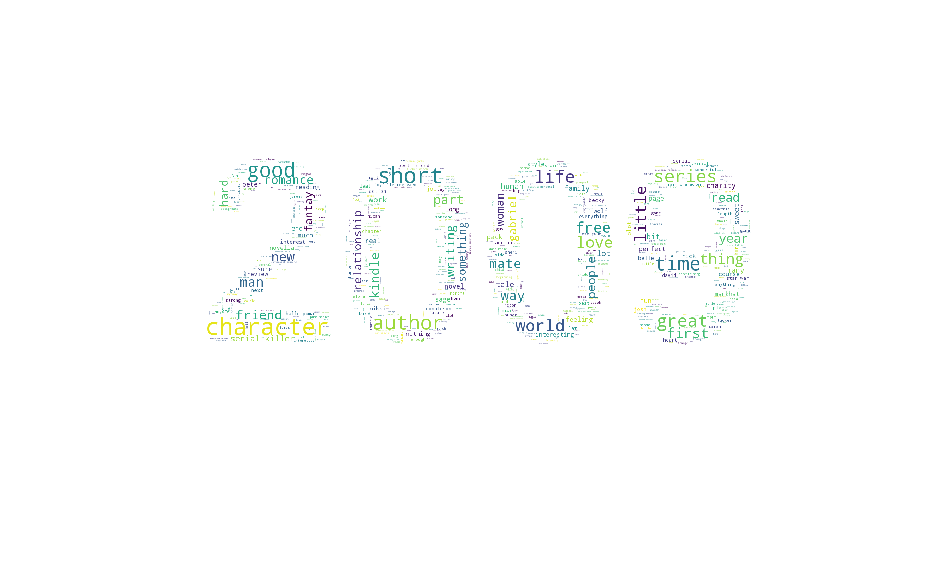

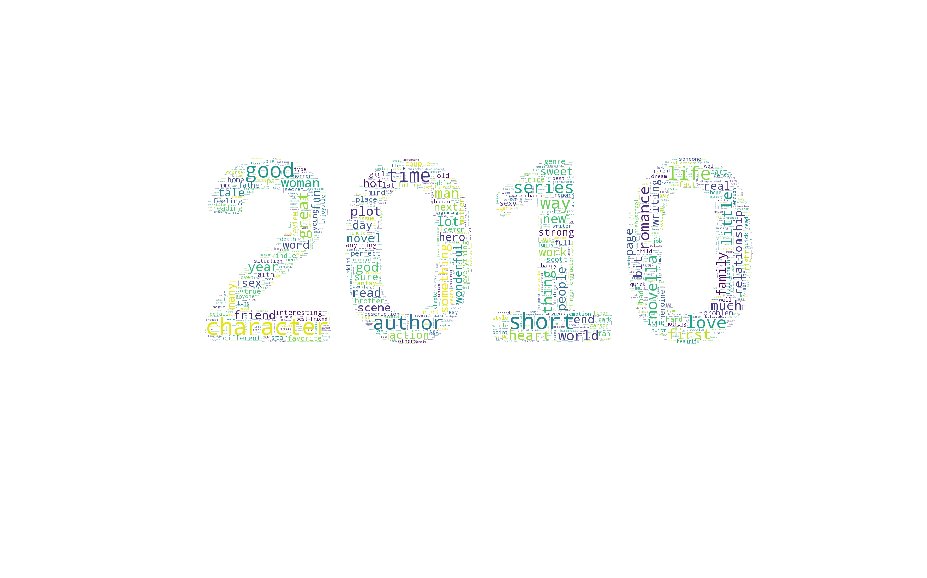

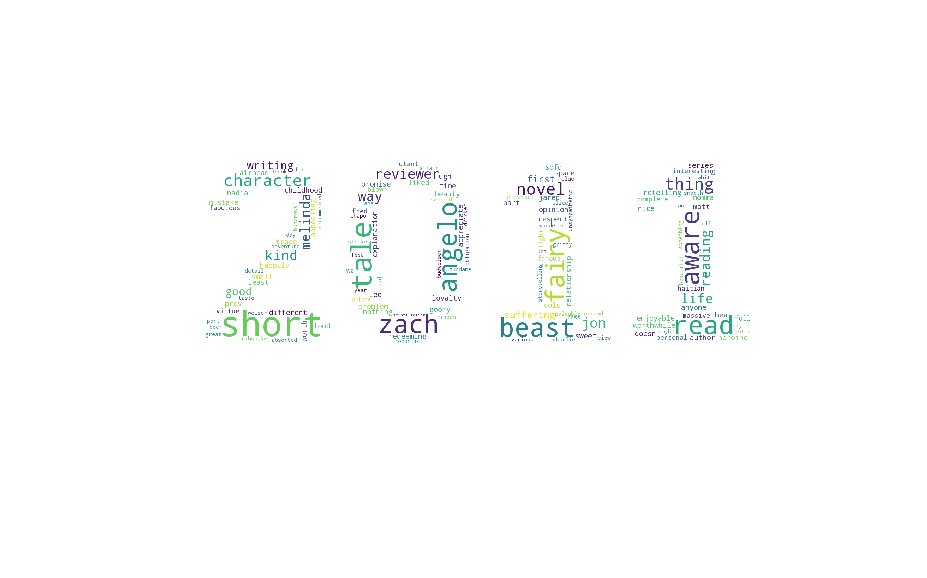

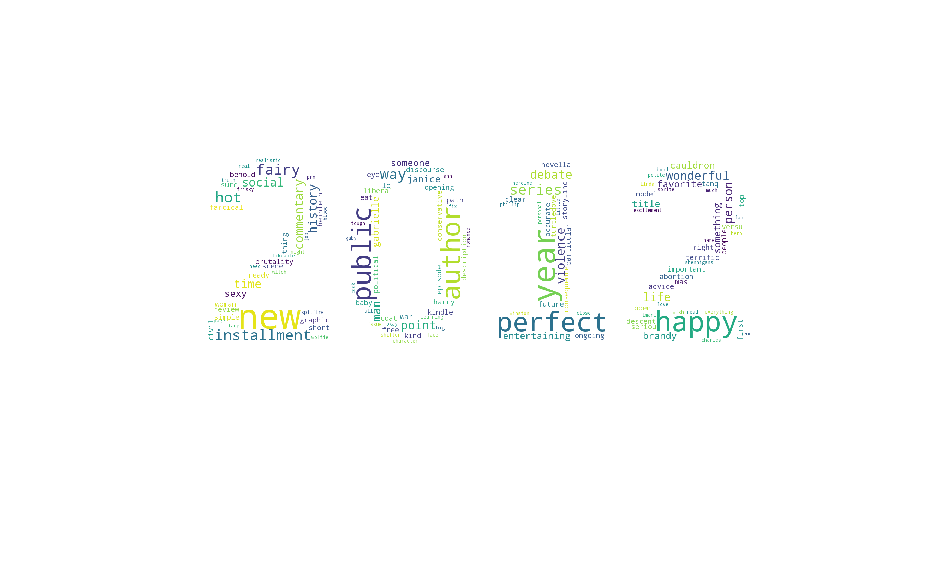

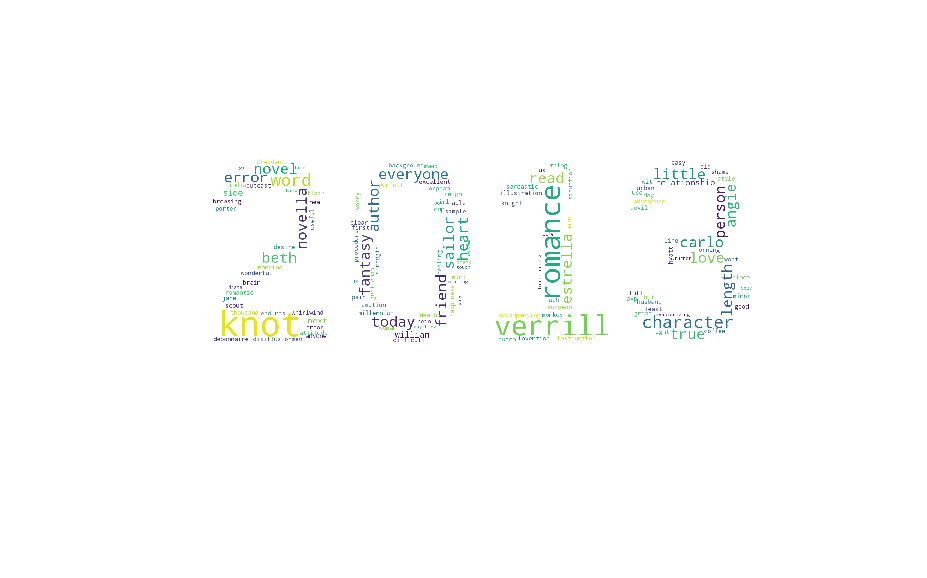

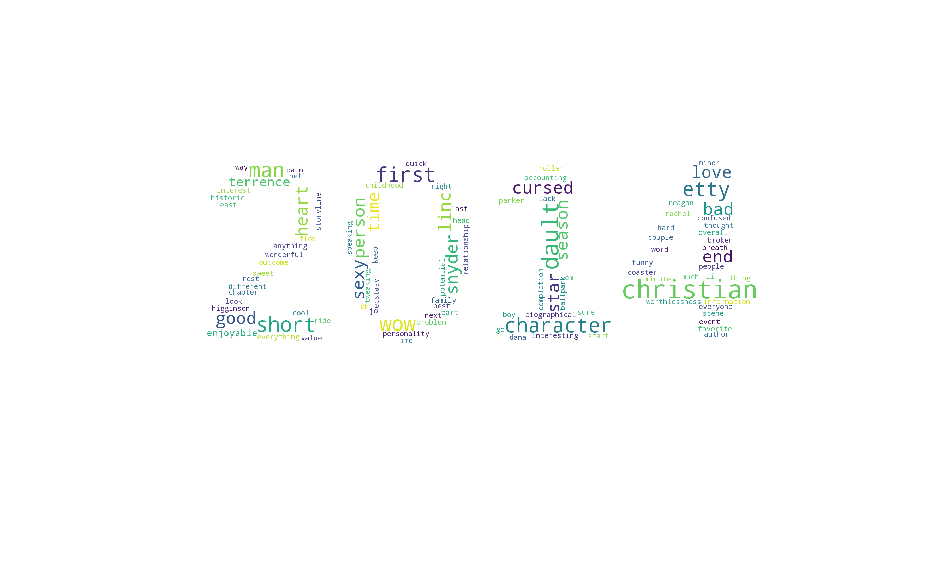

In [21]:
for i in range(len(name_sr)):
    picture = imread('img/' + name_sr[i])
    wordcloud = WordCloud(background_color="white",mask=picture,stopwords=stopword,max_words=2000,max_font_size=400,random_state=43).generate(review_sr[i])
    image_colors = ImageColorGenerator(picture)
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

From the word clouds above, we can easily find the keyword of each year.

P.S. The word clouds of short reads data in 2007 is a little strange because there are only few reviews, and after processing there are only several keywords left.

### For each category

Setting `unixReviewTime` as index in order to divide data by time.

In [22]:
Book = df_kindle_book.set_index('unixReviewTime')
Sr = df_kindle_sr.set_index('unixReviewTime')

Firstly, we select the review data only of **Literature & Fiction** category, and then using `groupby` to group the data and store each group in the list.

In [23]:
data_Book_fic= []
Book_fic = Book.loc[Book.category=="Literature & Fiction"]
for name, group in Book_fic.groupby(pd.TimeGrouper(freq='A')):
    data_Book_fic.append(group)

Using `textprocessing` fuction to process the review data.

In [24]:
review_book_fic = textprocessing(data_Book_fic)

`WordCloud` funciton allows us to get the frequency of each word.

After obtaining the frequency, we sort the frequency and we can get the keywords.

In [25]:
Word_fre = []
del_word = ['book','story','will','one','two','three','four','five','want','make','take','reader','mr']
for word in del_word:
    stopword = STOPWORDS.add(word)
for i in range(len(review_book_fic)):
    wordcloud = WordCloud(background_color="white",stopwords=stopword,max_words=2000,max_font_size=400,random_state=43).generate(review_book_fic[i])
    word_fre = []
    for key,value in wordcloud.words_.items():
        words = [key,value,value]
        word_fre.append(words)
    Word_fre.append(word_fre)
Word_fre.sort()

In the next part, we plan to show you the changes of keyword for `Literature & Fiction` category book over years. We implemented some methods to display animated plot here. 

However, there is some problem about embedding the plot into the jupyter notebook, so now you can only see one plot instead of the animated one. We are going to find some ways to fix this problem.

<IPython.core.display.Javascript object>


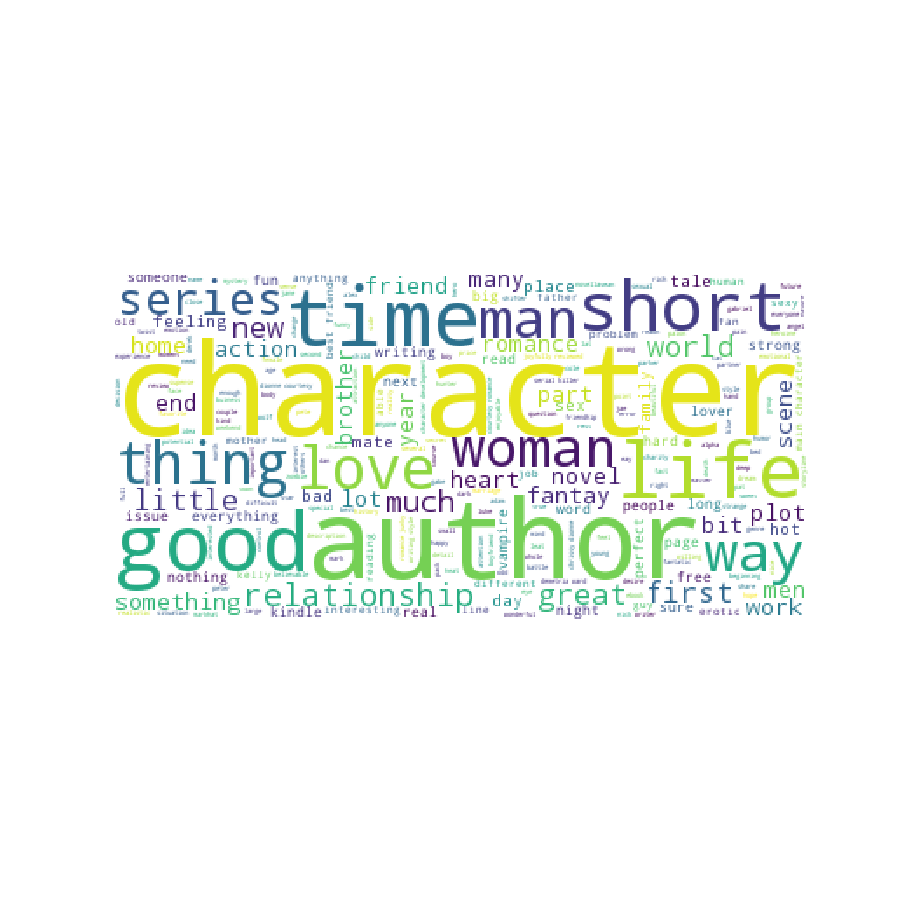

In [27]:
%matplotlib nbagg 
from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='html5')

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)    
wordcloud = WordCloud(background_color="white",stopwords=stopword,max_words=2000,max_font_size=400,random_state=43).generate(review_book_fic[0])
plt.imshow(wordcloud)
plt.axis("off")

def animate(i):
    #ax.clear()
    wordcloud = WordCloud(background_color="white",stopwords=stopword,max_words=2000,max_font_size=400,random_state=43).generate(review_book_fic[i])
    plt.imshow(wordcloud)
    plt.axis("off")
    return fig,ax

def init():
    wordcloud = WordCloud(background_color="white",stopwords=stopword,max_words=2000,max_font_size=400,random_state=43).generate(review_book_fic[0])
    plt.imshow(wordcloud)
    plt.axis("off")
    return fig,ax

ani = animation.FuncAnimation(fig=fig,func=animate,frames=100,init_func=init,interval=200,blit=True)
plt.show()

### 3.5 Review text analysis -- Style of review for each ratings:

In this part, we are going to study the style of review for each ratings. 

Properties of reviews to be or could be studied:
- Length of reviews
- Key word study and word cloud based on 3.4 
- Comprehensive sentiment analysis based on 3.2 using the sentiment score

### 3.6 Review text analysis -- Relationship between text and ratings/category
In this part, instead of using `SentimentIntensityAnalyzer`, we want to find another way to represents review text and find the relationship between text and the rating score, and one of followings is enough we think:

1. [Spectral Graph Theory](https://en.wikipedia.org/wiki/Spectral_graph_theory)
2. Machine Learning

#### Based mainly on Spectral Graph Theory

- **General Methods**:
    1. Vectorize text of reviews as the traing data.
    2. Use rating/category as the label for each observation.
    3. Generate the similarity matrix.
    4. Implement [Spectral Clustering](https://arxiv.org/abs/0711.0189) methods with k-Means algorithm.


- **We have done for this part so far**:
    1. Knowledge about the spectral clustering methods.
    2. Use TF-IDF to vectorize the text.
    3. Calculate the distance between each vector as the similarity matrix.
    4. Implement spectral clustering algorithm.
    5. But we cannot see any clusters.


- **Problems we are facing**:

    How to reasonably vectorize text and thus have good clustering result? That's what we are going to figure it out.

#### Based mainly on Machine Learning

- **General Methods**:
    1. Vectorize text of reviews as the traing data.
    2. Use rating/category as the label for each observation.
    3. Implement classifer methods.


- **Problems we are facing**:

    The same as above: How to reasonably vectorize text and thus have good classification result?

In [ ]:
# Since the result is not good, we don't upload code for this part.

### 3.7 Generate  automatically summary of review
In this part, we are going to generate automatically summary of review based on the text of review and/or the ratings.

**Method 1 -- Based on Ratings:**
1. Generate a vocabulary dictionary: For each ratings, find the key word based on the part of speech, like noun or adjective.
2. Build our own sentence based on the ratings one reviewer give.

**Method 2 -- Based on Reviews:**
1. Text cleaning: Remove unwanted characters and handle word embeddings
2. Design and build one neural network.
3. Train it based on reviews and corresponding summary in the dataset.
